In [1]:
!pip install EMD-signal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.16
    Uninstalling multiprocess-0.70.16:
      Successfully uninstalled multiprocess-0.70.16
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires dill<0.3.9,>=0.3.0, but you have dill 0.4.0 which is incompatible.
datasets 4.0.0

# Libraries

In [2]:
import yfinance
from PyEMD import EMD
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.signal import hilbert
import warnings
warnings.filterwarnings('ignore')

# Extracting Close price of stock

In [26]:
ticker = 'AAPL' #GC=F for Gold price
data = yf.download(ticker, start="2000-01-01", end="2025-01-01", progress=False)

# Use closing price
close_prices = data['Close'].values
signal = close_prices.astype(dtype=np.float64).flatten()
time = np.arange(len(signal), dtype=np.float64)
dates = data.index

# Applying EMD (Empirical Mode Decomposition)

In [27]:
# Step 3: Apply EMD
emd = EMD()
IMFs = emd.emd(signal, time)
print(IMFs.shape)

(9, 6289)


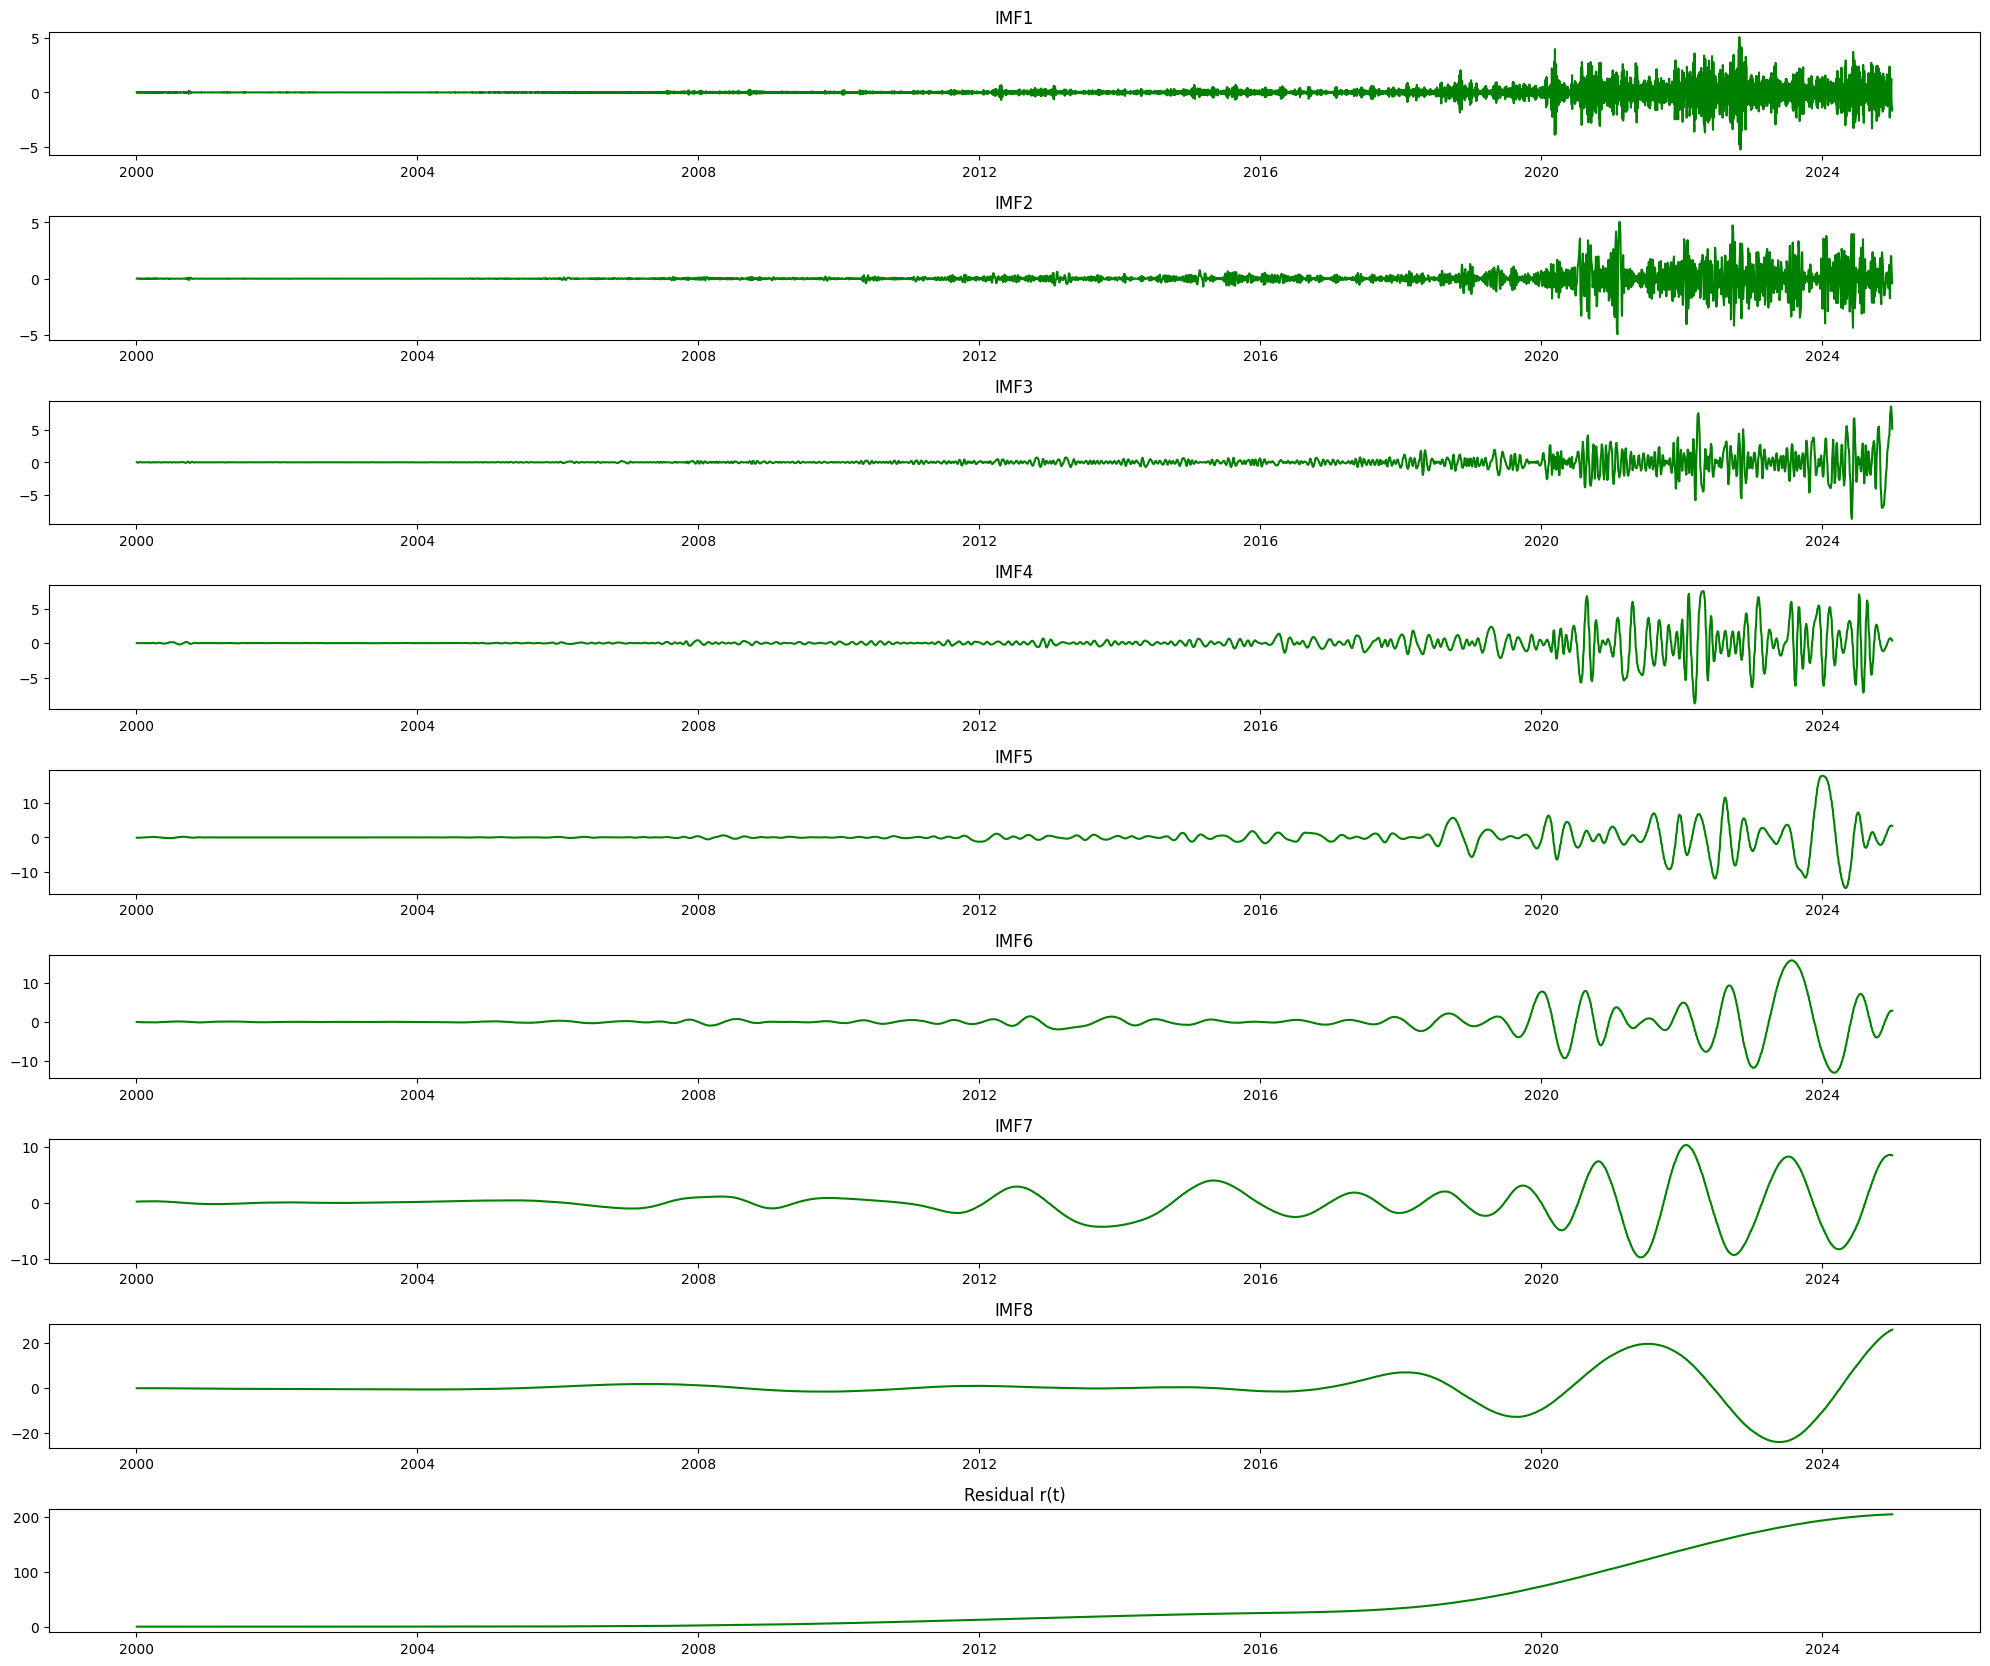

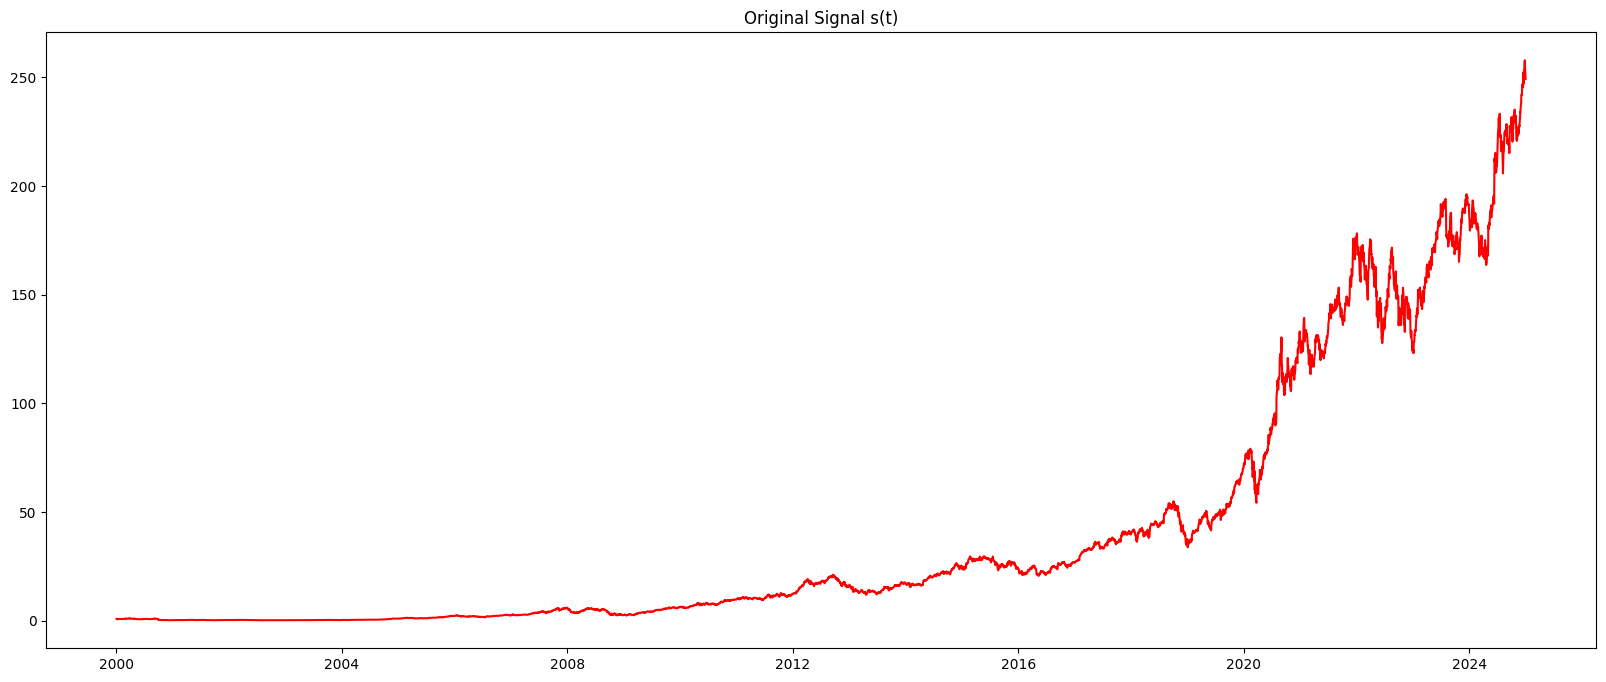

In [29]:
# plotting
plt.figure(figsize=(20, 2*len(IMFs) + 2))

for i, imf in enumerate(IMFs):
  plt.subplot(len(IMFs) + 2, 1, i + 2)
  plt.plot(dates, imf, 'g')
  if(i < len(IMFs) - 1): plt.title(f'IMF{i + 1}')
  else: plt.title('Residual r(t)')
plt.tight_layout()
plt.show()

# plt.subplot(len(IMFs) + 2, 1, len(IMFs) + 2)
plt.figure(figsize=(20, 8))
plt.plot(dates, signal, 'r')
plt.title('Original Signal s(t)')
plt.show()

# plt.tight_layout()
# plt.show()

# Applying Hilbert Transform

In [ ]:
# Hilbert Transform
hilbert_trans = np.array([hilbert(imf) for imf in IMFs])

absolute = np.abs(hilbert_trans)
amplitude = absolute ** 2

print(amplitude.shape)

(9, 6289)


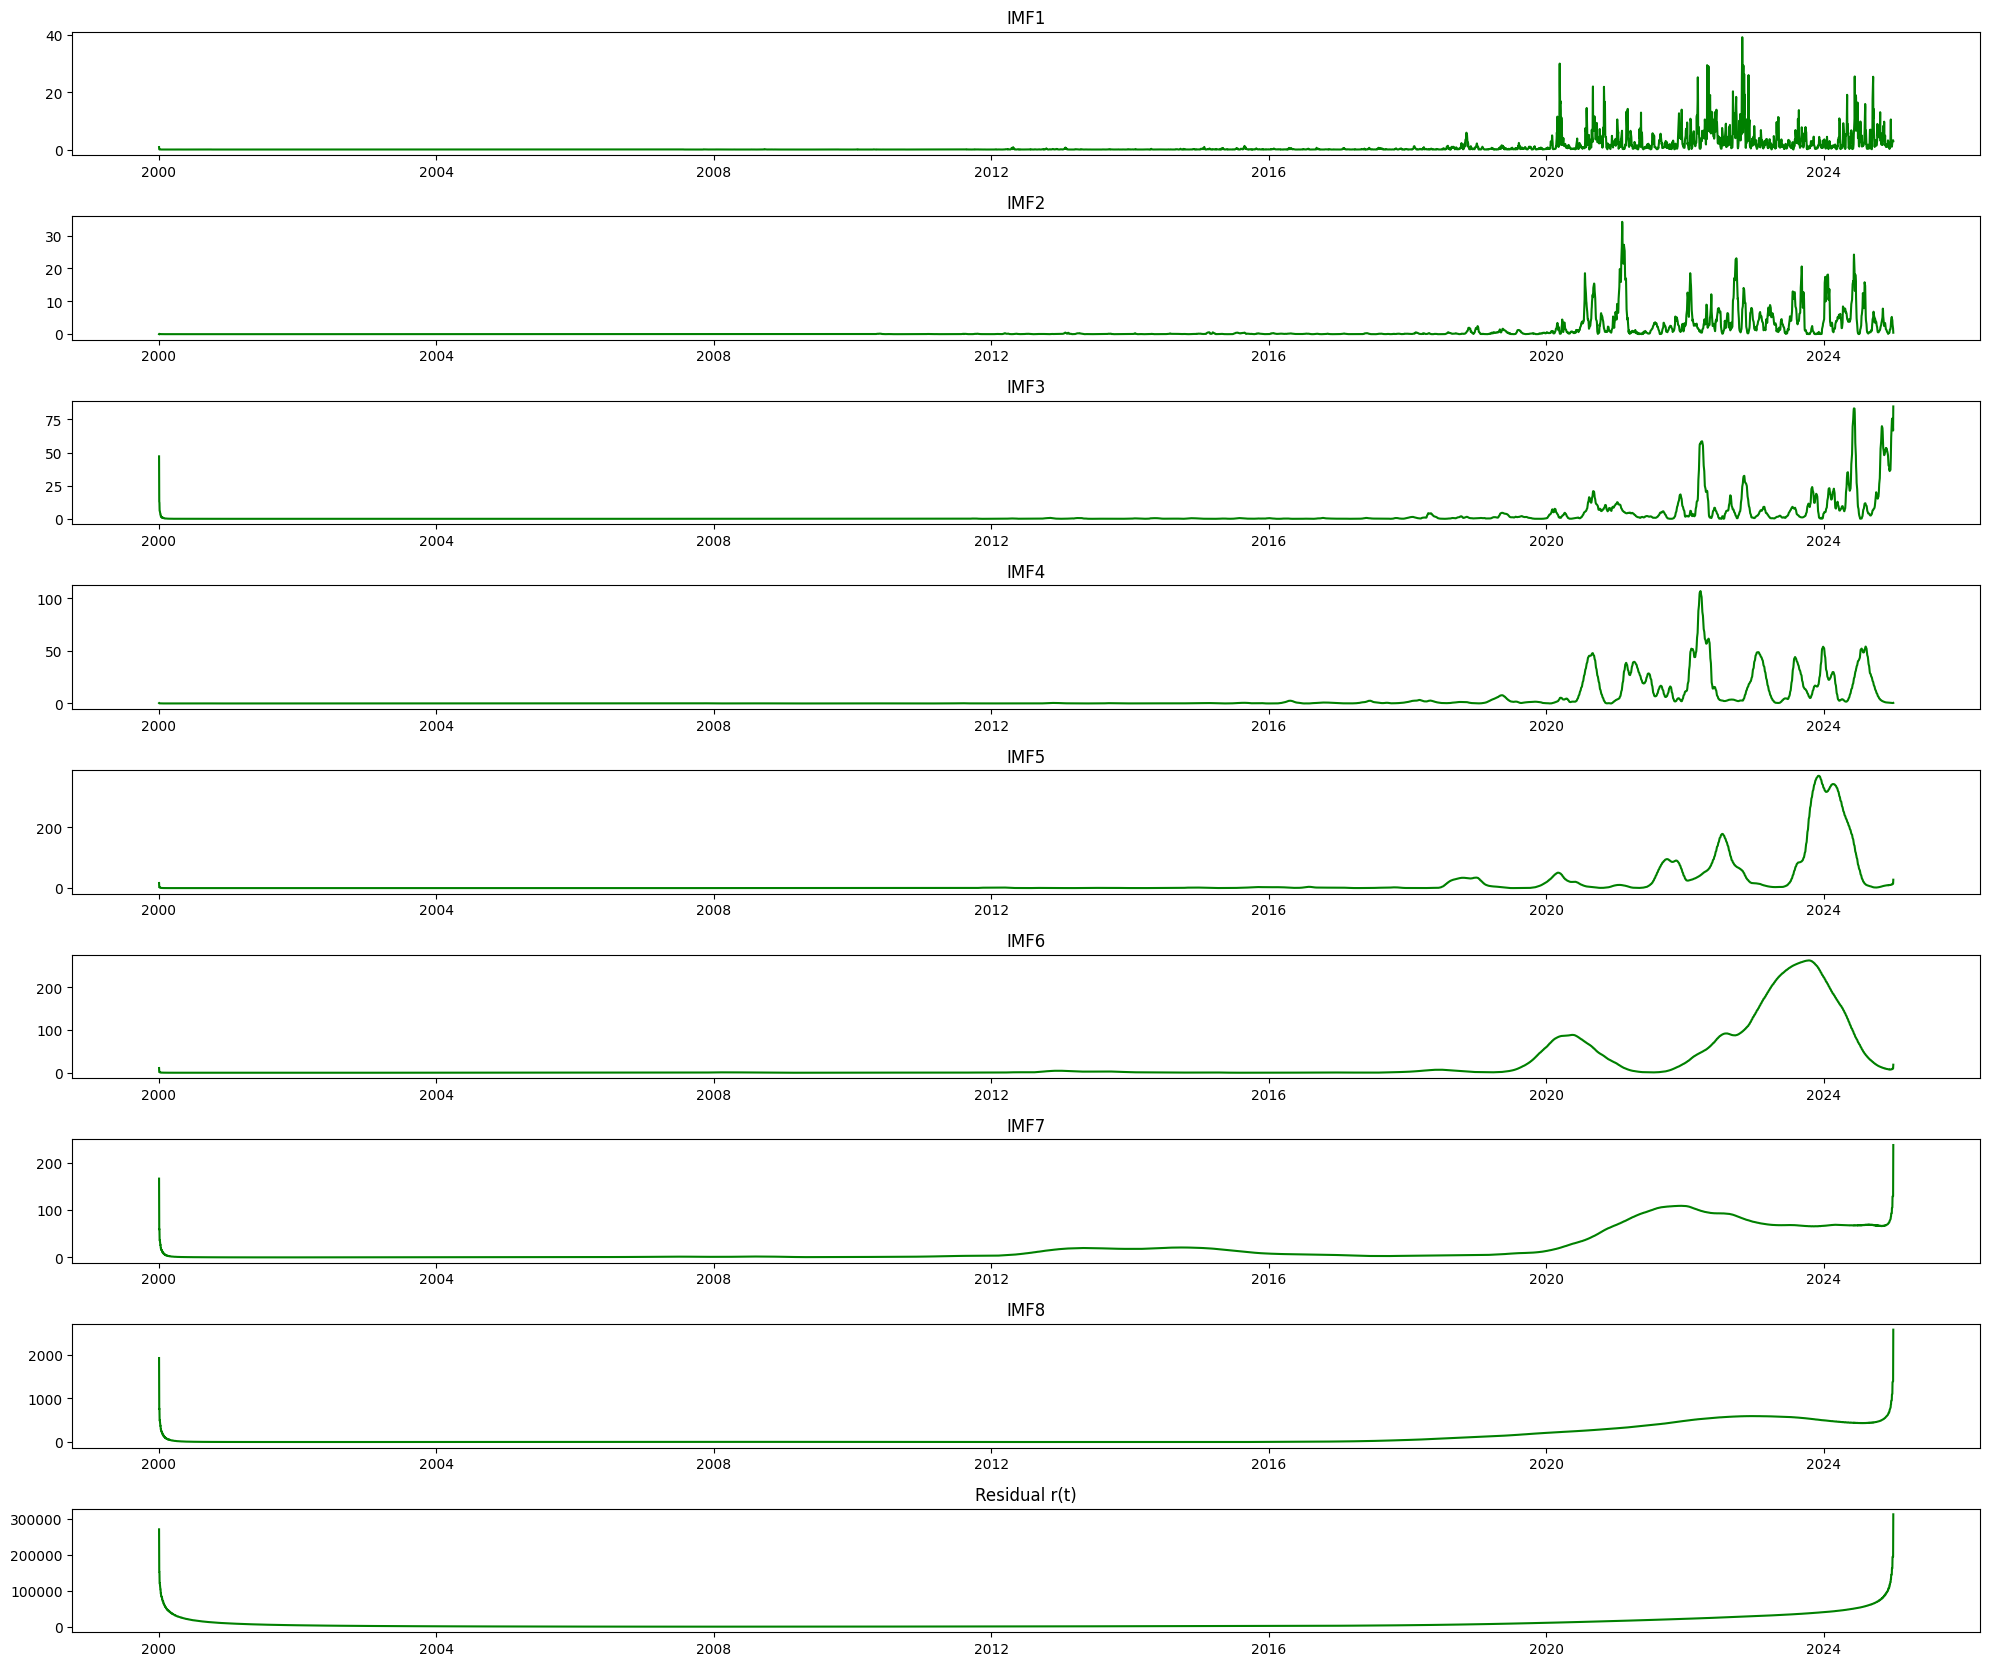

In [ ]:
plt.figure(figsize=(20, 2*len(IMFs) + 2))

for i, amp in enumerate(amplitude):
  plt.subplot(len(amplitude) + 2, 1, i + 2)
  plt.plot(dates, amp, 'g')
  if(i < len(IMFs) - 1): plt.title(f'IMF{i + 1}')
  else: plt.title('Residual r(t)')

plt.tight_layout()
plt.show()

In [ ]:
# Calculating Instantaneous energy
instantaneous_energy = np.sum(amplitude, axis = 0)
instantaneous_energy[instantaneous_energy == 0] = 1e-10

x_t = amplitude / instantaneous_energy


# Calculating mean of each IMF
means = np.mean(x_t, axis = 1)
print(means.shape)

(9,)


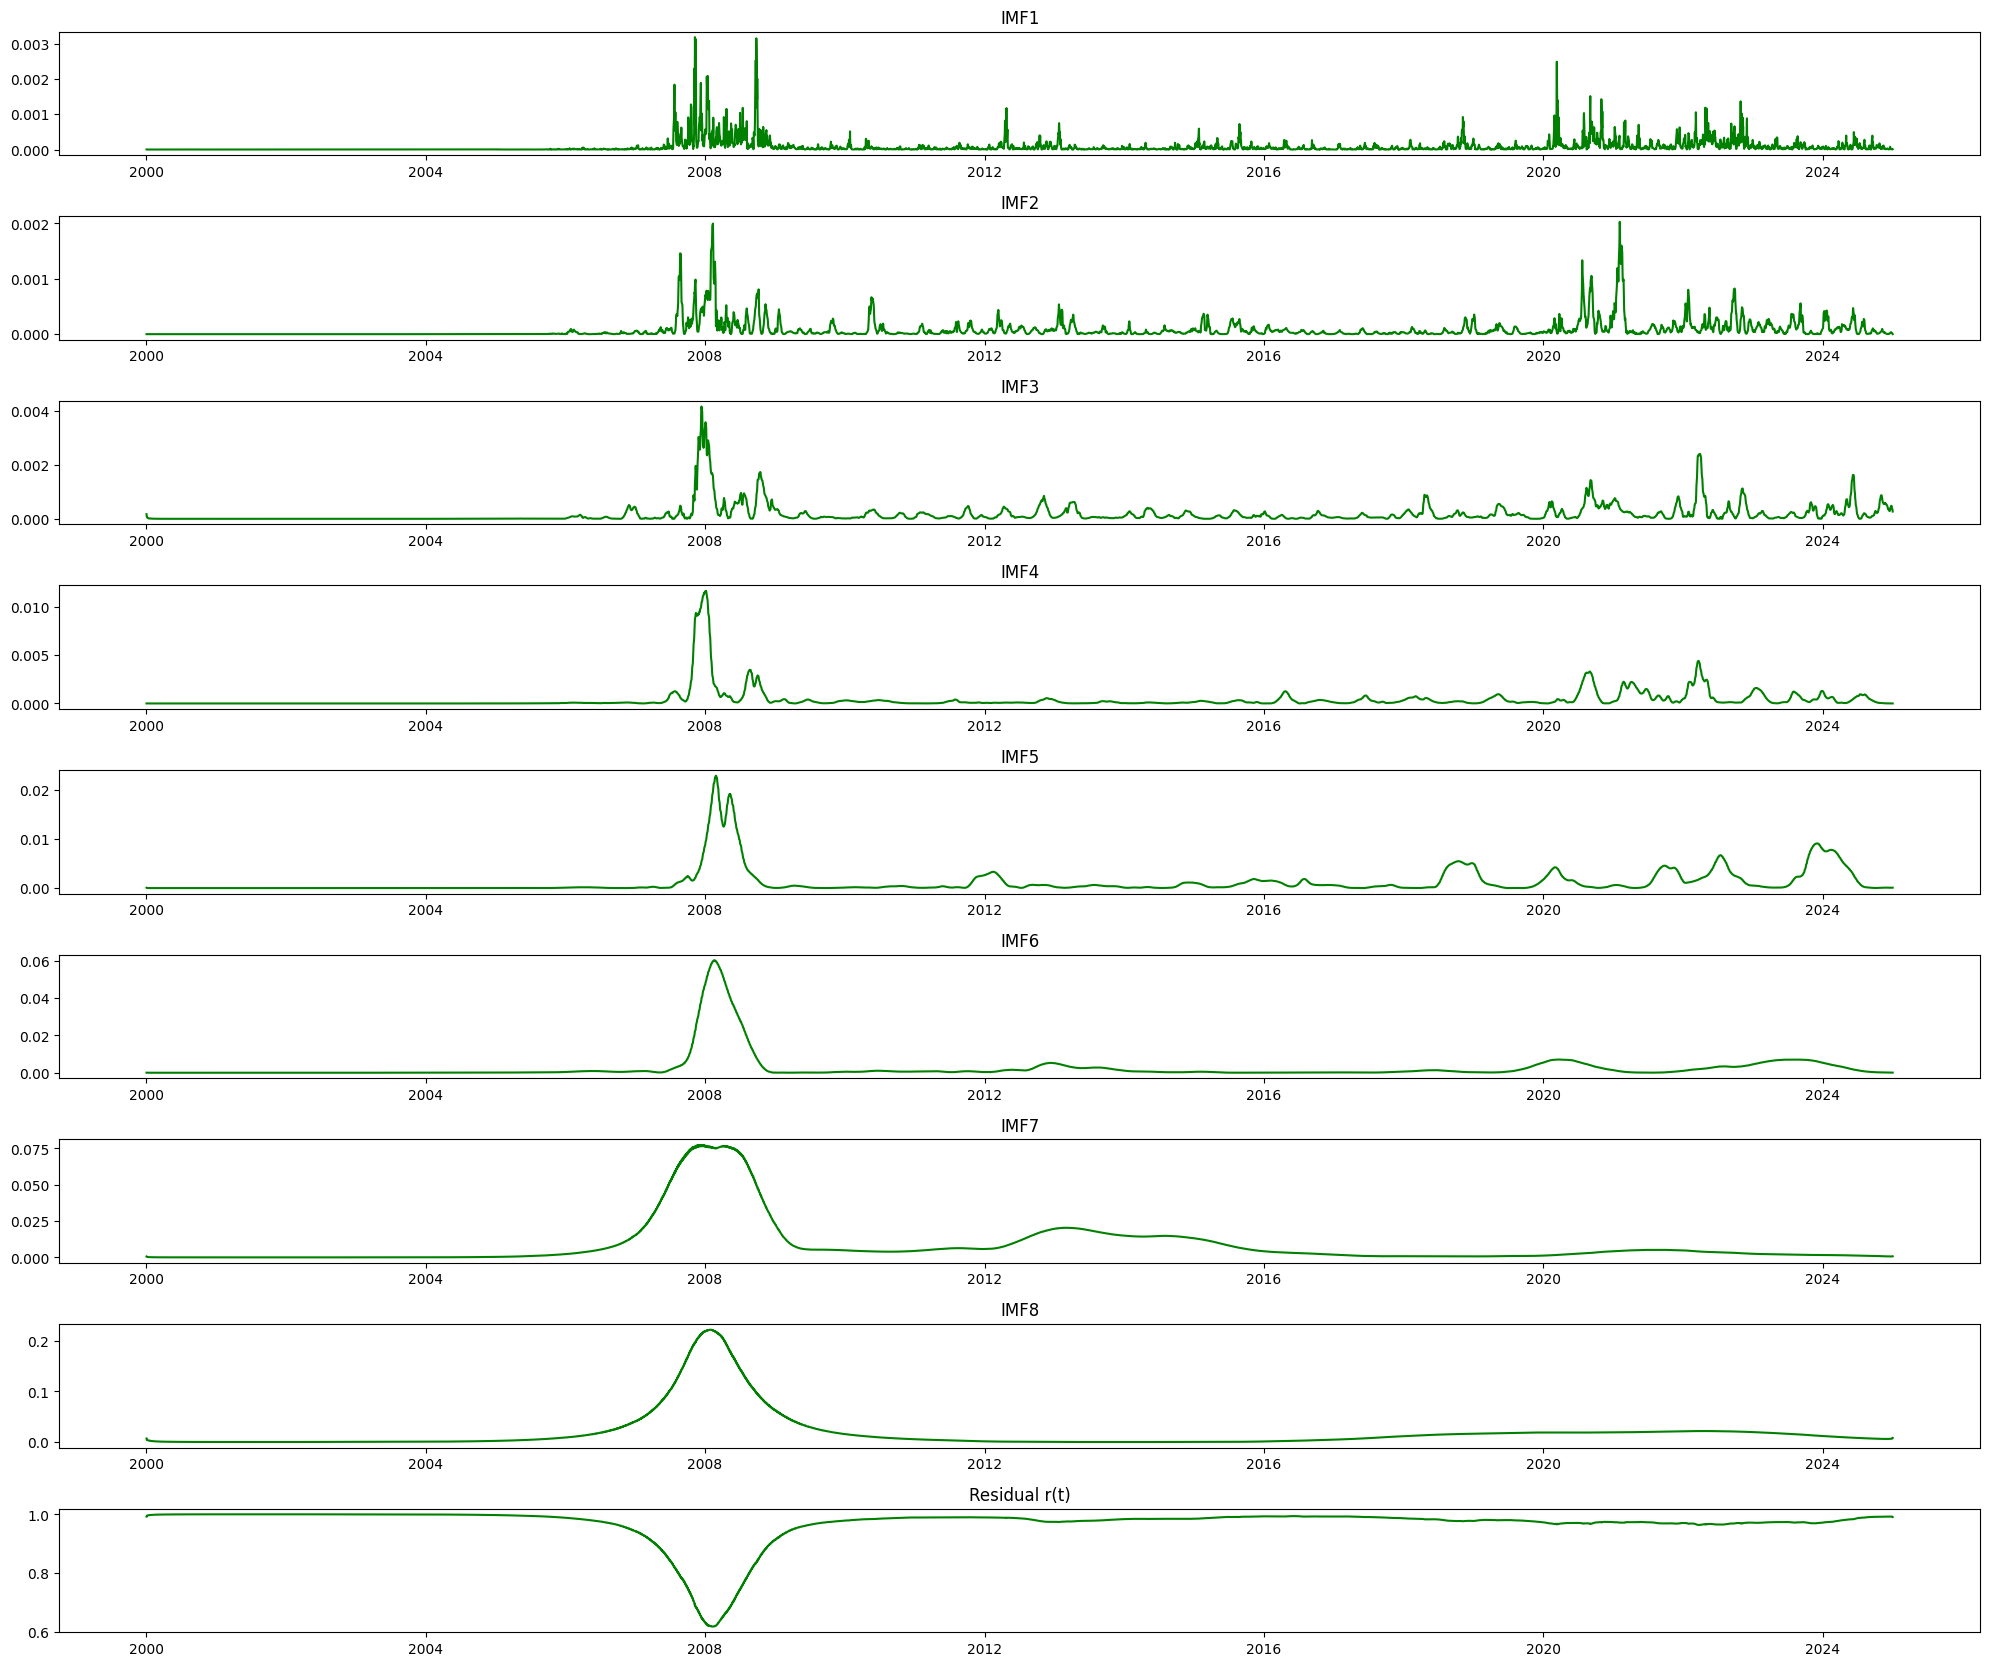

In [ ]:
plt.figure(figsize=(20, 2*len(IMFs) + 2))

for i, x_t_i in enumerate(x_t):
  plt.subplot(len(x_t) + 2, 1, i + 2)
  plt.plot(dates, x_t_i, 'g')
  if(i < len(IMFs) - 1): plt.title(f'IMF{i + 1}')
  else: plt.title('Residual r(t)')

plt.tight_layout()
plt.show()

In [ ]:
print(means)
print(means.round(3))

[7.72073944e-05 7.92098160e-05 1.71655240e-04 3.91063926e-04
 1.17872702e-03 2.53095087e-03 8.39783861e-03 1.86163517e-02
 9.68556995e-01]
[0.    0.    0.    0.    0.001 0.003 0.008 0.019 0.969]


In [ ]:
threshold = 0.001

signal_indices = np.where(means > threshold)[0]
print(signal_indices)

[4 5 6 7 8]


In [ ]:
denoised_signal = np.sum(IMFs[signal_indices, :], axis=0)

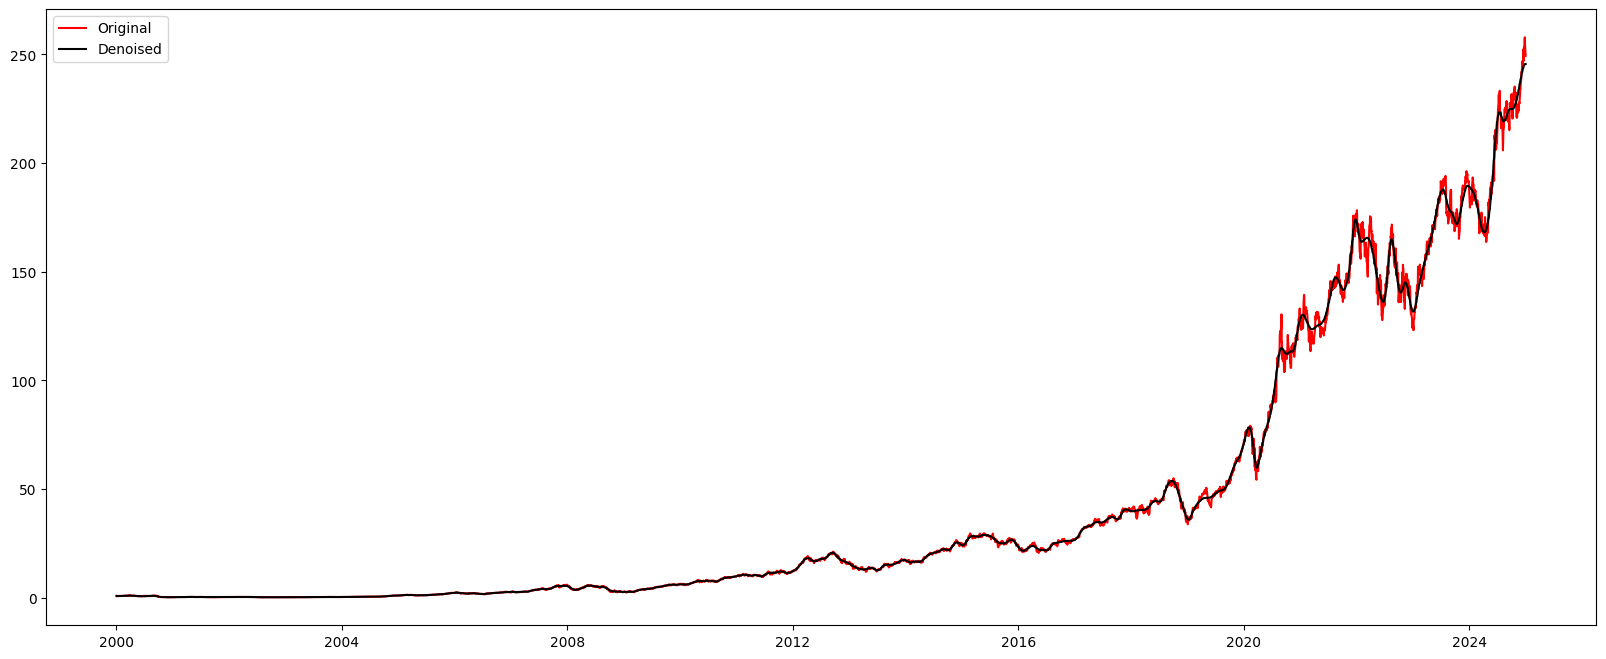

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(dates, signal, 'r', label='Original')
plt.plot(dates, denoised_signal, 'black', label='Denoised')
plt.legend()
plt.show()

# Comparison

## 1. ML Forecasting

APPROACH 1: Using Original Return Lags
  RMSE: 0.019927
  MAE:  0.014028
  R²:   0.002048
  Directional Accuracy: 53.22%
  Near-Zero Predictions: 35.72%

Reconstructed Price Metrics:
  RMSE: 2.6552
  MAE:  1.9688
  MAPE: 1.40%

APPROACH 2: Using Denoised Return Lags
  RMSE: 0.019629
  MAE:  0.013837
  R²:   0.031660
  Directional Accuracy: 54.97%
  Near-Zero Predictions: 25.22%

Reconstructed Price Metrics:
  RMSE: 2.6106
  MAE:  1.9440
  MAPE: 1.38%

FINAL RESULTS COMPARISON - RETURN PREDICTIONS
Metric                         Original        Denoised        Improvement    
----------------------------------------------------------------------
Return RMSE                    0.019927        0.019629                 1.49%
Return MAE                     0.014028        0.013837                 1.36%
Return R²                      0.002048        0.031660              1445.67%
Directional Accuracy           53.22           54.97                    1.75pp
Near-Zero Predictions (%)      35.7

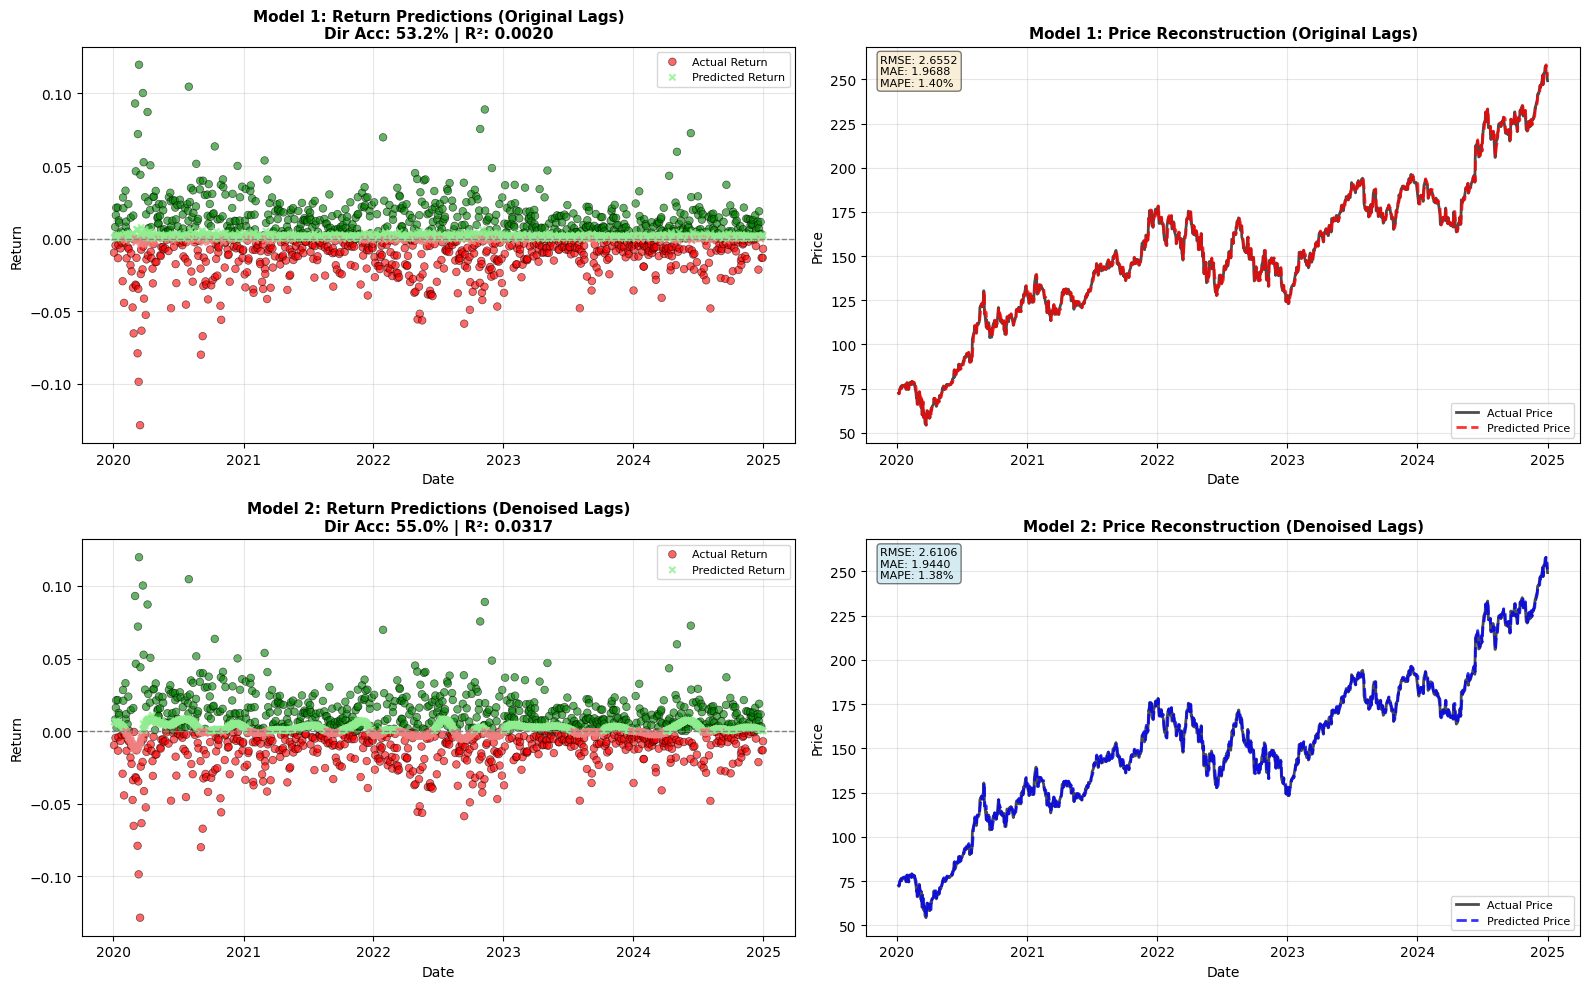

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

def build_return_features(series, lags=5):
    df = pd.DataFrame({"price": series})
    df["return"] = df["price"].pct_change()

    for i in range(1, lags + 1):
        df[f"lag_{i}"] = df["return"].shift(i)

    df = df.dropna()
    X = df[[f"lag_{i}" for i in range(1, lags + 1)]].values
    y = df["return"].values

    return X, y, df["price"].values

def directional_accuracy(y_true, y_pred):
    correct = np.sum((np.sign(y_true) == np.sign(y_pred)))
    return (correct / len(y_true)) * 100

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    dir_acc = directional_accuracy(y_true, y_pred)
    near_zero = np.sum(np.abs(y_pred) < 0.001) / len(y_pred) * 100

    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Directional Accuracy (%)': dir_acc,
        'Near-Zero Predictions (%)': near_zero
    }

# ===== APPROACH 1: Original Return Lags → Predict Original Return =====
print("=" * 70)
print("APPROACH 1: Using Original Return Lags")
print("=" * 70)

X_orig, y_orig_ret, prices_orig = build_return_features(signal, lags=5)

Xo_train, Xo_test, yo_train, yo_test = train_test_split(
    X_orig, y_orig_ret, test_size=0.2, shuffle=False
)

prices_train, prices_test = train_test_split(
    prices_orig, test_size=0.2, shuffle=False
)

model_orig = LinearRegression()
model_orig.fit(Xo_train, yo_train)
orig_pred_ret = model_orig.predict(Xo_test)

orig_metrics = calculate_metrics(yo_test, orig_pred_ret)

print(f"  RMSE: {orig_metrics['RMSE']:.6f}")
print(f"  MAE:  {orig_metrics['MAE']:.6f}")
print(f"  R²:   {orig_metrics['R2']:.6f}")
print(f"  Directional Accuracy: {orig_metrics['Directional Accuracy (%)']:.2f}%")
print(f"  Near-Zero Predictions: {orig_metrics['Near-Zero Predictions (%)']:.2f}%")

# Reconstruct prices: Price_t+1 = Price_t * (1 + Return)
orig_pred_price = prices_test[:-1] * (1 + orig_pred_ret[1:])
orig_actual_price = prices_test[1:]

orig_rmse_price = np.sqrt(mean_squared_error(orig_actual_price, orig_pred_price))
orig_mae_price = mean_absolute_error(orig_actual_price, orig_pred_price)
orig_mape_price = np.mean(np.abs((orig_actual_price - orig_pred_price) / orig_actual_price)) * 100

print(f"\nReconstructed Price Metrics:")
print(f"  RMSE: {orig_rmse_price:.4f}")
print(f"  MAE:  {orig_mae_price:.4f}")
print(f"  MAPE: {orig_mape_price:.2f}%")

# ===== APPROACH 2: Denoised Return Lags → Predict Original Return =====
print("\n" + "=" * 70)
print("APPROACH 2: Using Denoised Return Lags")
print("=" * 70)

X_denoised, y_denoised_ret, prices_denoised = build_return_features(denoised_signal, lags=5)

# Align lengths
min_len = min(len(X_orig), len(X_denoised))
X_orig_aligned = X_orig[-min_len:]
y_orig_ret_aligned = y_orig_ret[-min_len:]
X_denoised_aligned = X_denoised[-min_len:]
prices_orig_aligned = prices_orig[-min_len:]

split_idx = int(len(X_denoised_aligned) * 0.8)

Xd_train = X_denoised_aligned[:split_idx]
Xd_test = X_denoised_aligned[split_idx:]
yd_train = y_orig_ret_aligned[:split_idx]  # Target: Original Return
yd_test = y_orig_ret_aligned[split_idx:]

prices_train_d = prices_orig_aligned[:split_idx]
prices_test_d = prices_orig_aligned[split_idx:]

model_denoised = LinearRegression()
model_denoised.fit(Xd_train, yd_train)
den_pred_ret = model_denoised.predict(Xd_test)

den_metrics = calculate_metrics(yd_test, den_pred_ret)

print(f"  RMSE: {den_metrics['RMSE']:.6f}")
print(f"  MAE:  {den_metrics['MAE']:.6f}")
print(f"  R²:   {den_metrics['R2']:.6f}")
print(f"  Directional Accuracy: {den_metrics['Directional Accuracy (%)']:.2f}%")
print(f"  Near-Zero Predictions: {den_metrics['Near-Zero Predictions (%)']:.2f}%")

den_pred_price = prices_test_d[:-1] * (1 + den_pred_ret[1:])
den_actual_price = prices_test_d[1:]

den_rmse_price = np.sqrt(mean_squared_error(den_actual_price, den_pred_price))
den_mae_price = mean_absolute_error(den_actual_price, den_pred_price)
den_mape_price = np.mean(np.abs((den_actual_price - den_pred_price) / den_actual_price)) * 100

print(f"\nReconstructed Price Metrics:")
print(f"  RMSE: {den_rmse_price:.4f}")
print(f"  MAE:  {den_mae_price:.4f}")
print(f"  MAPE: {den_mape_price:.2f}%")

# ===== RESULTS COMPARISON =====
print("\n" + "=" * 70)
print("FINAL RESULTS COMPARISON - RETURN PREDICTIONS")
print("=" * 70)
print(f"{'Metric':<30} {'Original':<15} {'Denoised':<15} {'Improvement':<15}")
print("-" * 70)
print(f"{'Return RMSE':<30} {orig_metrics['RMSE']:<15.6f} {den_metrics['RMSE']:<15.6f} {((orig_metrics['RMSE'] - den_metrics['RMSE']) / orig_metrics['RMSE'] * 100):>13.2f}%")
print(f"{'Return MAE':<30} {orig_metrics['MAE']:<15.6f} {den_metrics['MAE']:<15.6f} {((orig_metrics['MAE'] - den_metrics['MAE']) / orig_metrics['MAE'] * 100):>13.2f}%")
print(f"{'Return R²':<30} {orig_metrics['R2']:<15.6f} {den_metrics['R2']:<15.6f} {((den_metrics['R2'] - orig_metrics['R2']) / abs(orig_metrics['R2']) * 100):>13.2f}%")
print(f"{'Directional Accuracy':<30} {orig_metrics['Directional Accuracy (%)']:<15.2f} {den_metrics['Directional Accuracy (%)']:<15.2f} {(den_metrics['Directional Accuracy (%)'] - orig_metrics['Directional Accuracy (%)']):>13.2f}pp")
print(f"{'Near-Zero Predictions (%)':<30} {orig_metrics['Near-Zero Predictions (%)']:<15.2f} {den_metrics['Near-Zero Predictions (%)']:<15.2f}")

print("\n" + "=" * 70)
print("FINAL RESULTS COMPARISON - RECONSTRUCTED PRICES")
print("=" * 70)
print(f"{'Metric':<30} {'Original':<15} {'Denoised':<15} {'Improvement':<15}")
print("-" * 70)
print(f"{'Price RMSE':<30} {orig_rmse_price:<15.4f} {den_rmse_price:<15.4f} {((orig_rmse_price - den_rmse_price) / orig_rmse_price * 100):>13.2f}%")
print(f"{'Price MAE':<30} {orig_mae_price:<15.4f} {den_mae_price:<15.4f} {((orig_mae_price - den_mae_price) / orig_mae_price * 100):>13.2f}%")
print(f"{'Price MAPE':<30} {orig_mape_price:<15.2f} {den_mape_price:<15.2f} {((orig_mape_price - den_mape_price) / orig_mape_price * 100):>13.2f}%")

# Create results dataframe
results_df = pd.DataFrame({
    'Model': ['Original Lags', 'Denoised Lags'],
    'Return RMSE': [orig_metrics['RMSE'], den_metrics['RMSE']],
    'Return R²': [orig_metrics['R2'], den_metrics['R2']],
    'Directional Acc (%)': [orig_metrics['Directional Accuracy (%)'], den_metrics['Directional Accuracy (%)']],
    'Price RMSE': [orig_rmse_price, den_rmse_price],
    'Price MAPE (%)': [orig_mape_price, den_mape_price]
})

print("\n")
print(results_df.to_markdown(index=False, floatfmt=('.6f', '.6f', '.6f', '.2f', '.4f', '.2f')))

# ===== VISUALIZATION =====
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

test_start_idx = len(signal) - len(yo_test)
test_dates = dates[test_start_idx:test_start_idx + len(yo_test)]

# Plot 1: Original Return Predictions
ax1 = axes[0, 0]
ax1.scatter(test_dates, yo_test, c=['green' if r > 0 else 'red' for r in yo_test],
            alpha=0.6, s=30, label='Actual Return', edgecolors='black', linewidth=0.5)
ax1.scatter(test_dates, orig_pred_ret, c=['lightgreen' if r > 0 else 'lightcoral' for r in orig_pred_ret],
            alpha=0.8, s=20, marker='x', label='Predicted Return')
ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax1.set_title(f'Model 1: Return Predictions (Original Lags)\nDir Acc: {orig_metrics["Directional Accuracy (%)"]:.1f}% | R²: {orig_metrics["R2"]:.4f}',
              fontsize=11, fontweight='bold')
ax1.set_xlabel('Date', fontsize=10)
ax1.set_ylabel('Return', fontsize=10)
ax1.legend(loc='best', fontsize=8)
ax1.grid(True, alpha=0.3)

# Plot 2: Original Price Reconstruction
ax2 = axes[0, 1]
price_dates = test_dates[1:]
ax2.plot(price_dates, orig_actual_price, color='black', linewidth=2, label='Actual Price', alpha=0.7)
ax2.plot(price_dates, orig_pred_price, color='red', linestyle='--', linewidth=2,
         label='Predicted Price', alpha=0.8)
ax2.set_title('Model 1: Price Reconstruction (Original Lags)', fontsize=11, fontweight='bold')
ax2.set_xlabel('Date', fontsize=10)
ax2.set_ylabel('Price', fontsize=10)
ax2.legend(loc='best', fontsize=8)
ax2.grid(True, alpha=0.3)
ax2.text(0.02, 0.98, f'RMSE: {orig_rmse_price:.4f}\nMAE: {orig_mae_price:.4f}\nMAPE: {orig_mape_price:.2f}%',
         transform=ax2.transAxes, fontsize=8, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: Denoised Return Predictions with Direction Indicators
test_start_idx_d = len(signal) - len(yd_test)
test_dates_d = dates[test_start_idx_d:test_start_idx_d + len(yd_test)]

ax3 = axes[1, 0]
ax3.scatter(test_dates_d, yd_test, c=['green' if r > 0 else 'red' for r in yd_test],
            alpha=0.6, s=30, label='Actual Return', edgecolors='black', linewidth=0.5)
ax3.scatter(test_dates_d, den_pred_ret, c=['lightgreen' if r > 0 else 'lightcoral' for r in den_pred_ret],
            alpha=0.8, s=20, marker='x', label='Predicted Return')
ax3.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax3.set_title(f'Model 2: Return Predictions (Denoised Lags)\nDir Acc: {den_metrics["Directional Accuracy (%)"]:.1f}% | R²: {den_metrics["R2"]:.4f}',
              fontsize=11, fontweight='bold')
ax3.set_xlabel('Date', fontsize=10)
ax3.set_ylabel('Return', fontsize=10)
ax3.legend(loc='best', fontsize=8)
ax3.grid(True, alpha=0.3)

# Plot 4: Denoised Price Reconstruction
ax4 = axes[1, 1]
price_dates_d = test_dates_d[1:]
ax4.plot(price_dates_d, den_actual_price, color='black', linewidth=2, label='Actual Price', alpha=0.7)
ax4.plot(price_dates_d, den_pred_price, color='blue', linestyle='--', linewidth=2,
         label='Predicted Price', alpha=0.8)
ax4.set_title('Model 2: Price Reconstruction (Denoised Lags)', fontsize=11, fontweight='bold')
ax4.set_xlabel('Date', fontsize=10)
ax4.set_ylabel('Price', fontsize=10)
ax4.legend(loc='best', fontsize=8)
ax4.grid(True, alpha=0.3)
ax4.text(0.02, 0.98, f'RMSE: {den_rmse_price:.4f}\nMAE: {den_mae_price:.4f}\nMAPE: {den_mape_price:.2f}%',
         transform=ax4.transAxes, fontsize=8, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

## 2. Mutual Information Score

In [ ]:
from sklearn.metrics import mutual_info_score

print('Original Signal:', mutual_info_score(signal[:-1], signal[1:]))
print('Denoised Signal:', mutual_info_score(denoised_signal[:-1], signal[1:]))

Original Signal: 8.5500552286368
Denoised Signal: 8.647896081382196


## 3. Variance

In [ ]:
print('Original Signal:', np.var(np.diff(signal)))
print('Denoised Signal:', np.var(np.diff(denoised_signal)))

Original Signal: 1.4904792147544916
Denoised Signal: 0.04742495916975389


## 4. SNR

In [ ]:
def snr(signal, noise):
    return 10 * np.log10(np.sum(signal**2) / np.sum(noise**2))

noise = signal - denoised_signal

print('SNR:', snr(signal, noise))

SNR: 31.17858031139441


## 5. Volatility Reduction

In [ ]:
vol_original = np.std(np.diff(signal))
vol_denoised = np.std(np.diff(denoised_signal))

print('Original:', vol_original)
print('Denoised:', vol_denoised)

Original: 1.220851839804688
Denoised: 0.21777272365875824


# For Other Signals

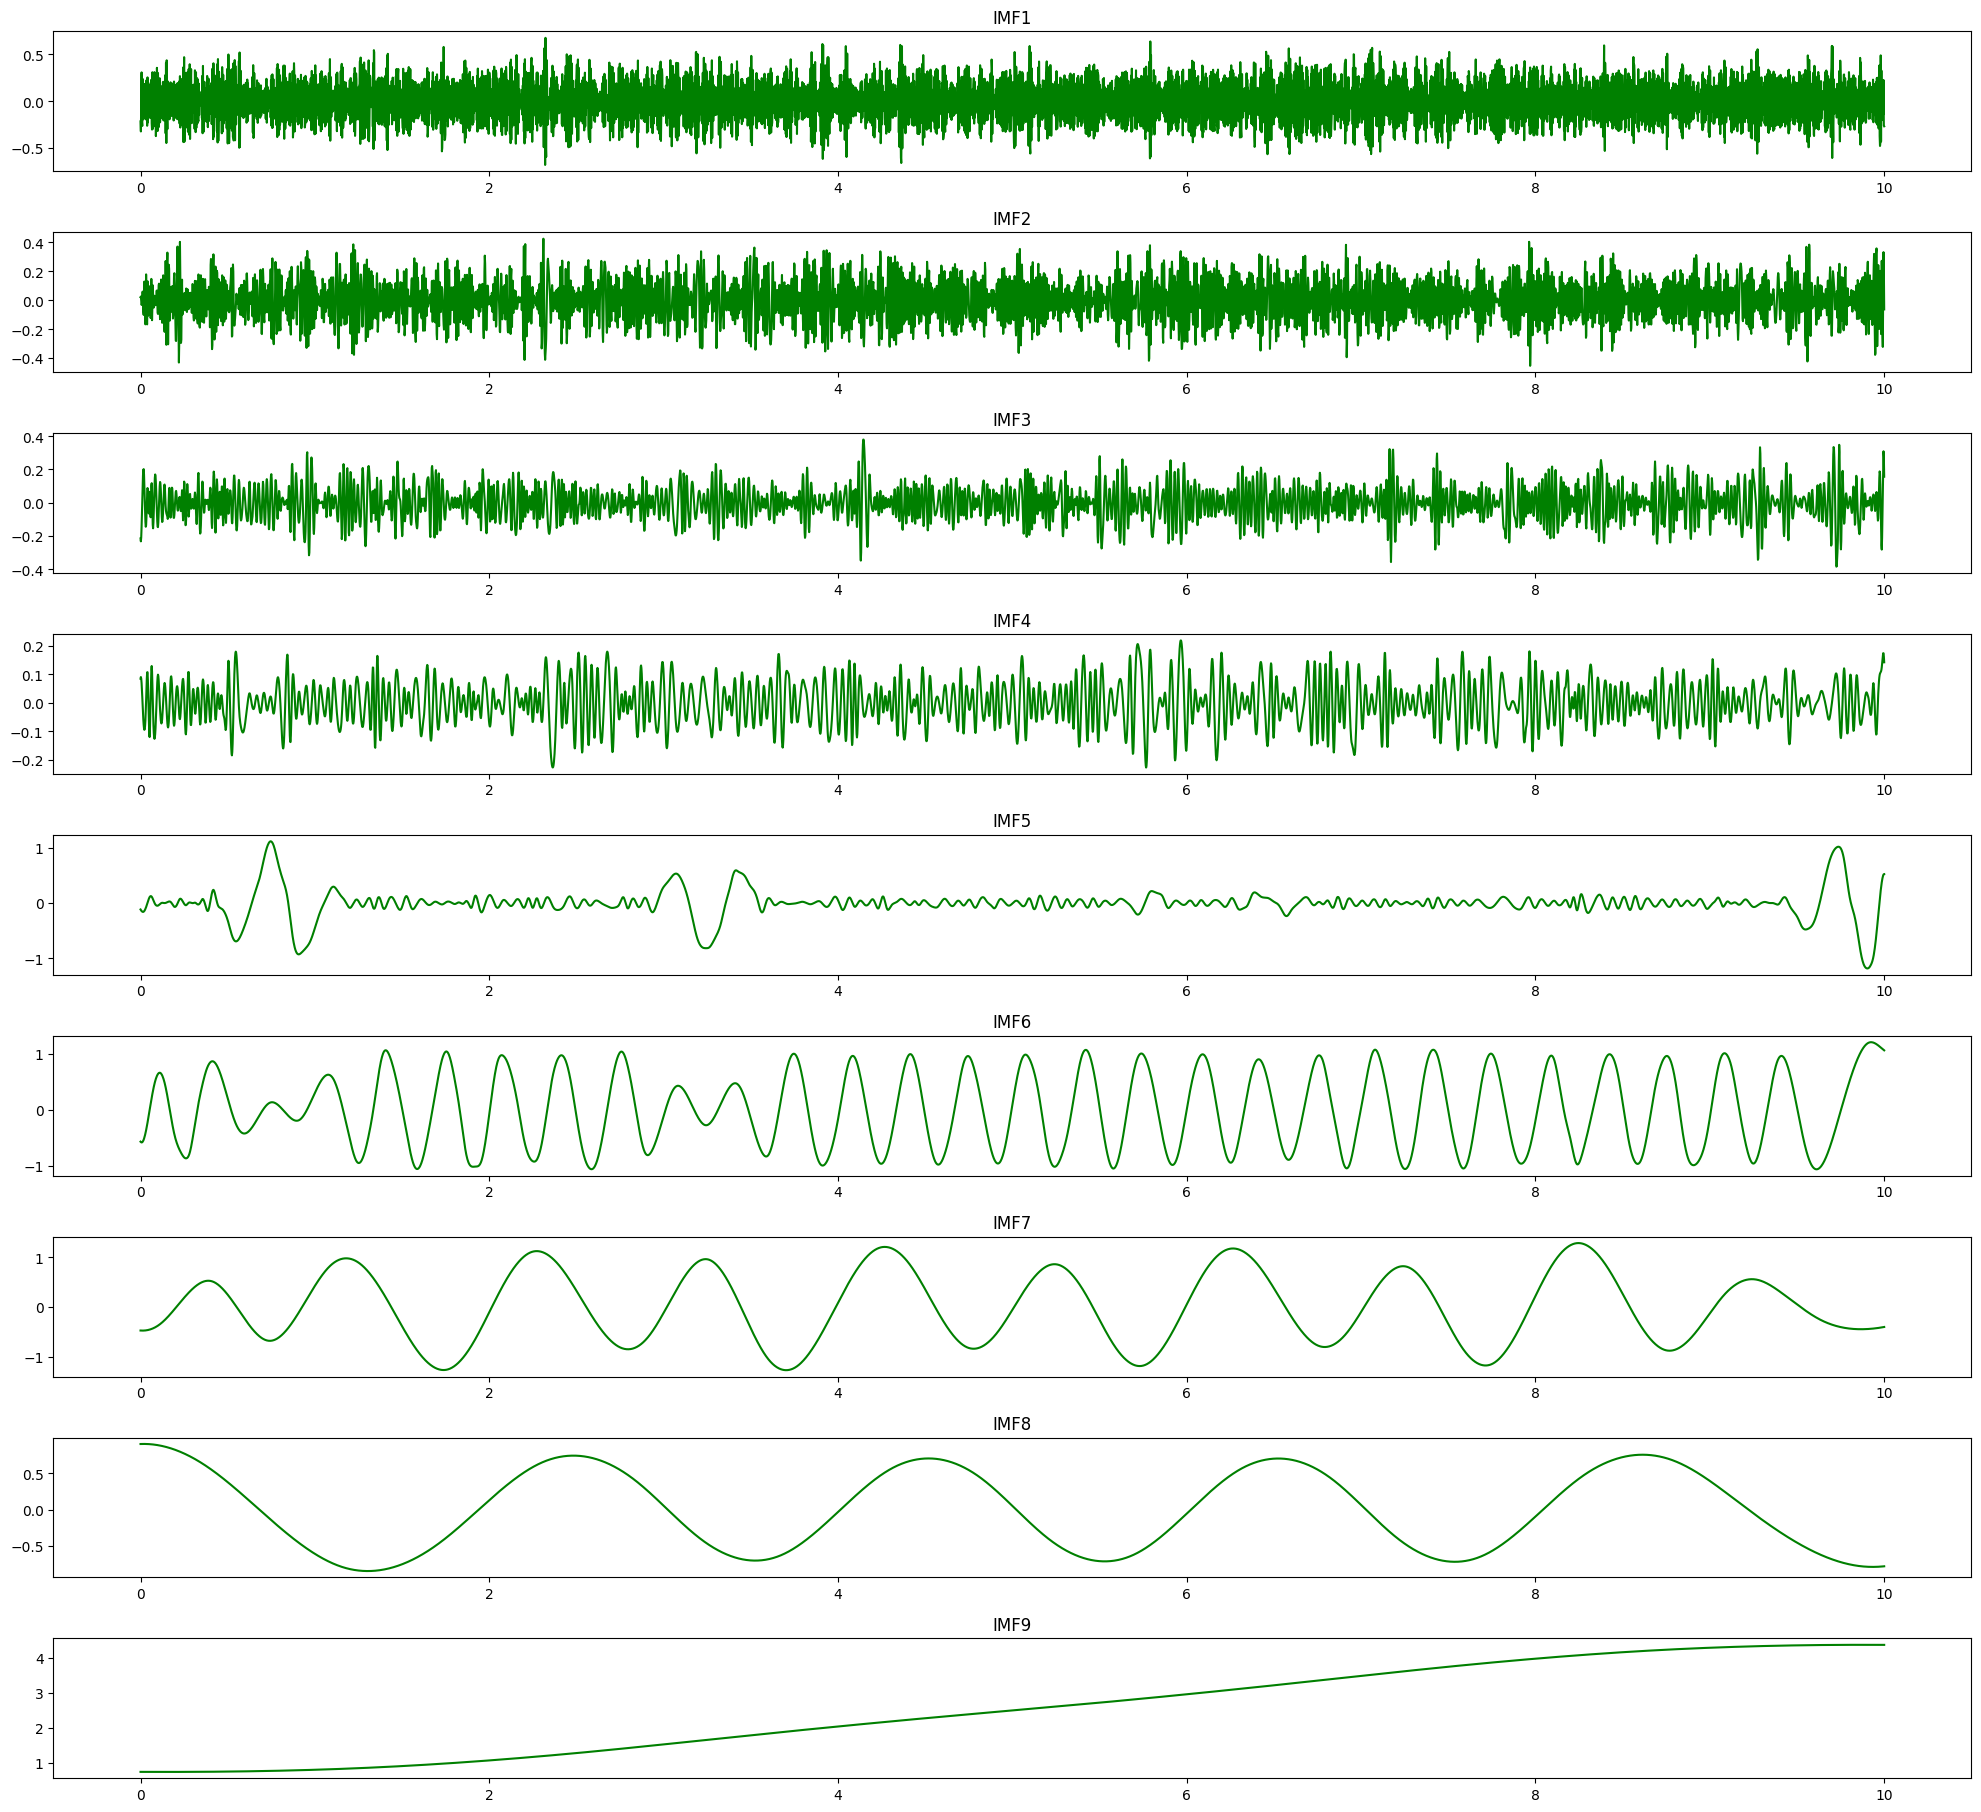

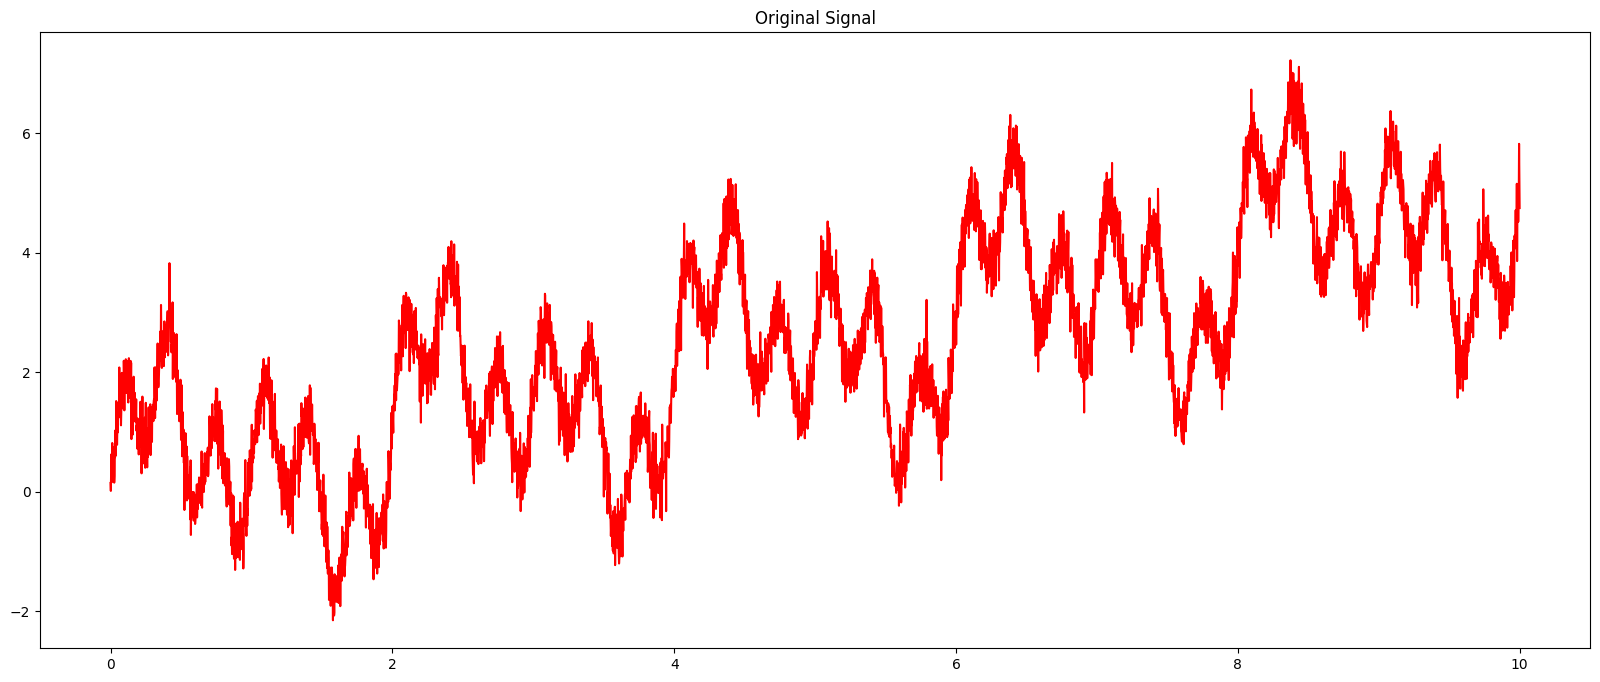

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import EMD
from scipy.signal import hilbert
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==========================
# Synthetic Signal Definition
# ==========================
np.random.seed(42)
t = np.linspace(0, 10, 5000)
noise = 0.3 * np.random.randn(len(t))
signal = 0.5 * t + np.sin(np.pi * t) + np.sin(2 * np.pi * t) + np.sin(6 * np.pi * t) + noise

# ======================
# Empirical Mode Decomposition
# ======================
emd = EMD()
IMFs = emd.emd(signal, t)

# ======================
# Plot IMFs
# ======================
plt.figure(figsize=(20, 2 * (len(IMFs) + 1)))
for i, imf in enumerate(IMFs):
    plt.subplot(len(IMFs) + 1, 1, i + 1)
    plt.plot(t, imf, 'g')
    plt.title(f'IMF{i+1}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 8))
# plt.subplot(len(IMFs) + 1, 1, len(IMFs) + 1)
plt.plot(t, signal, 'r')
plt.title('Original Signal')
# plt.tight_layout()
plt.show()

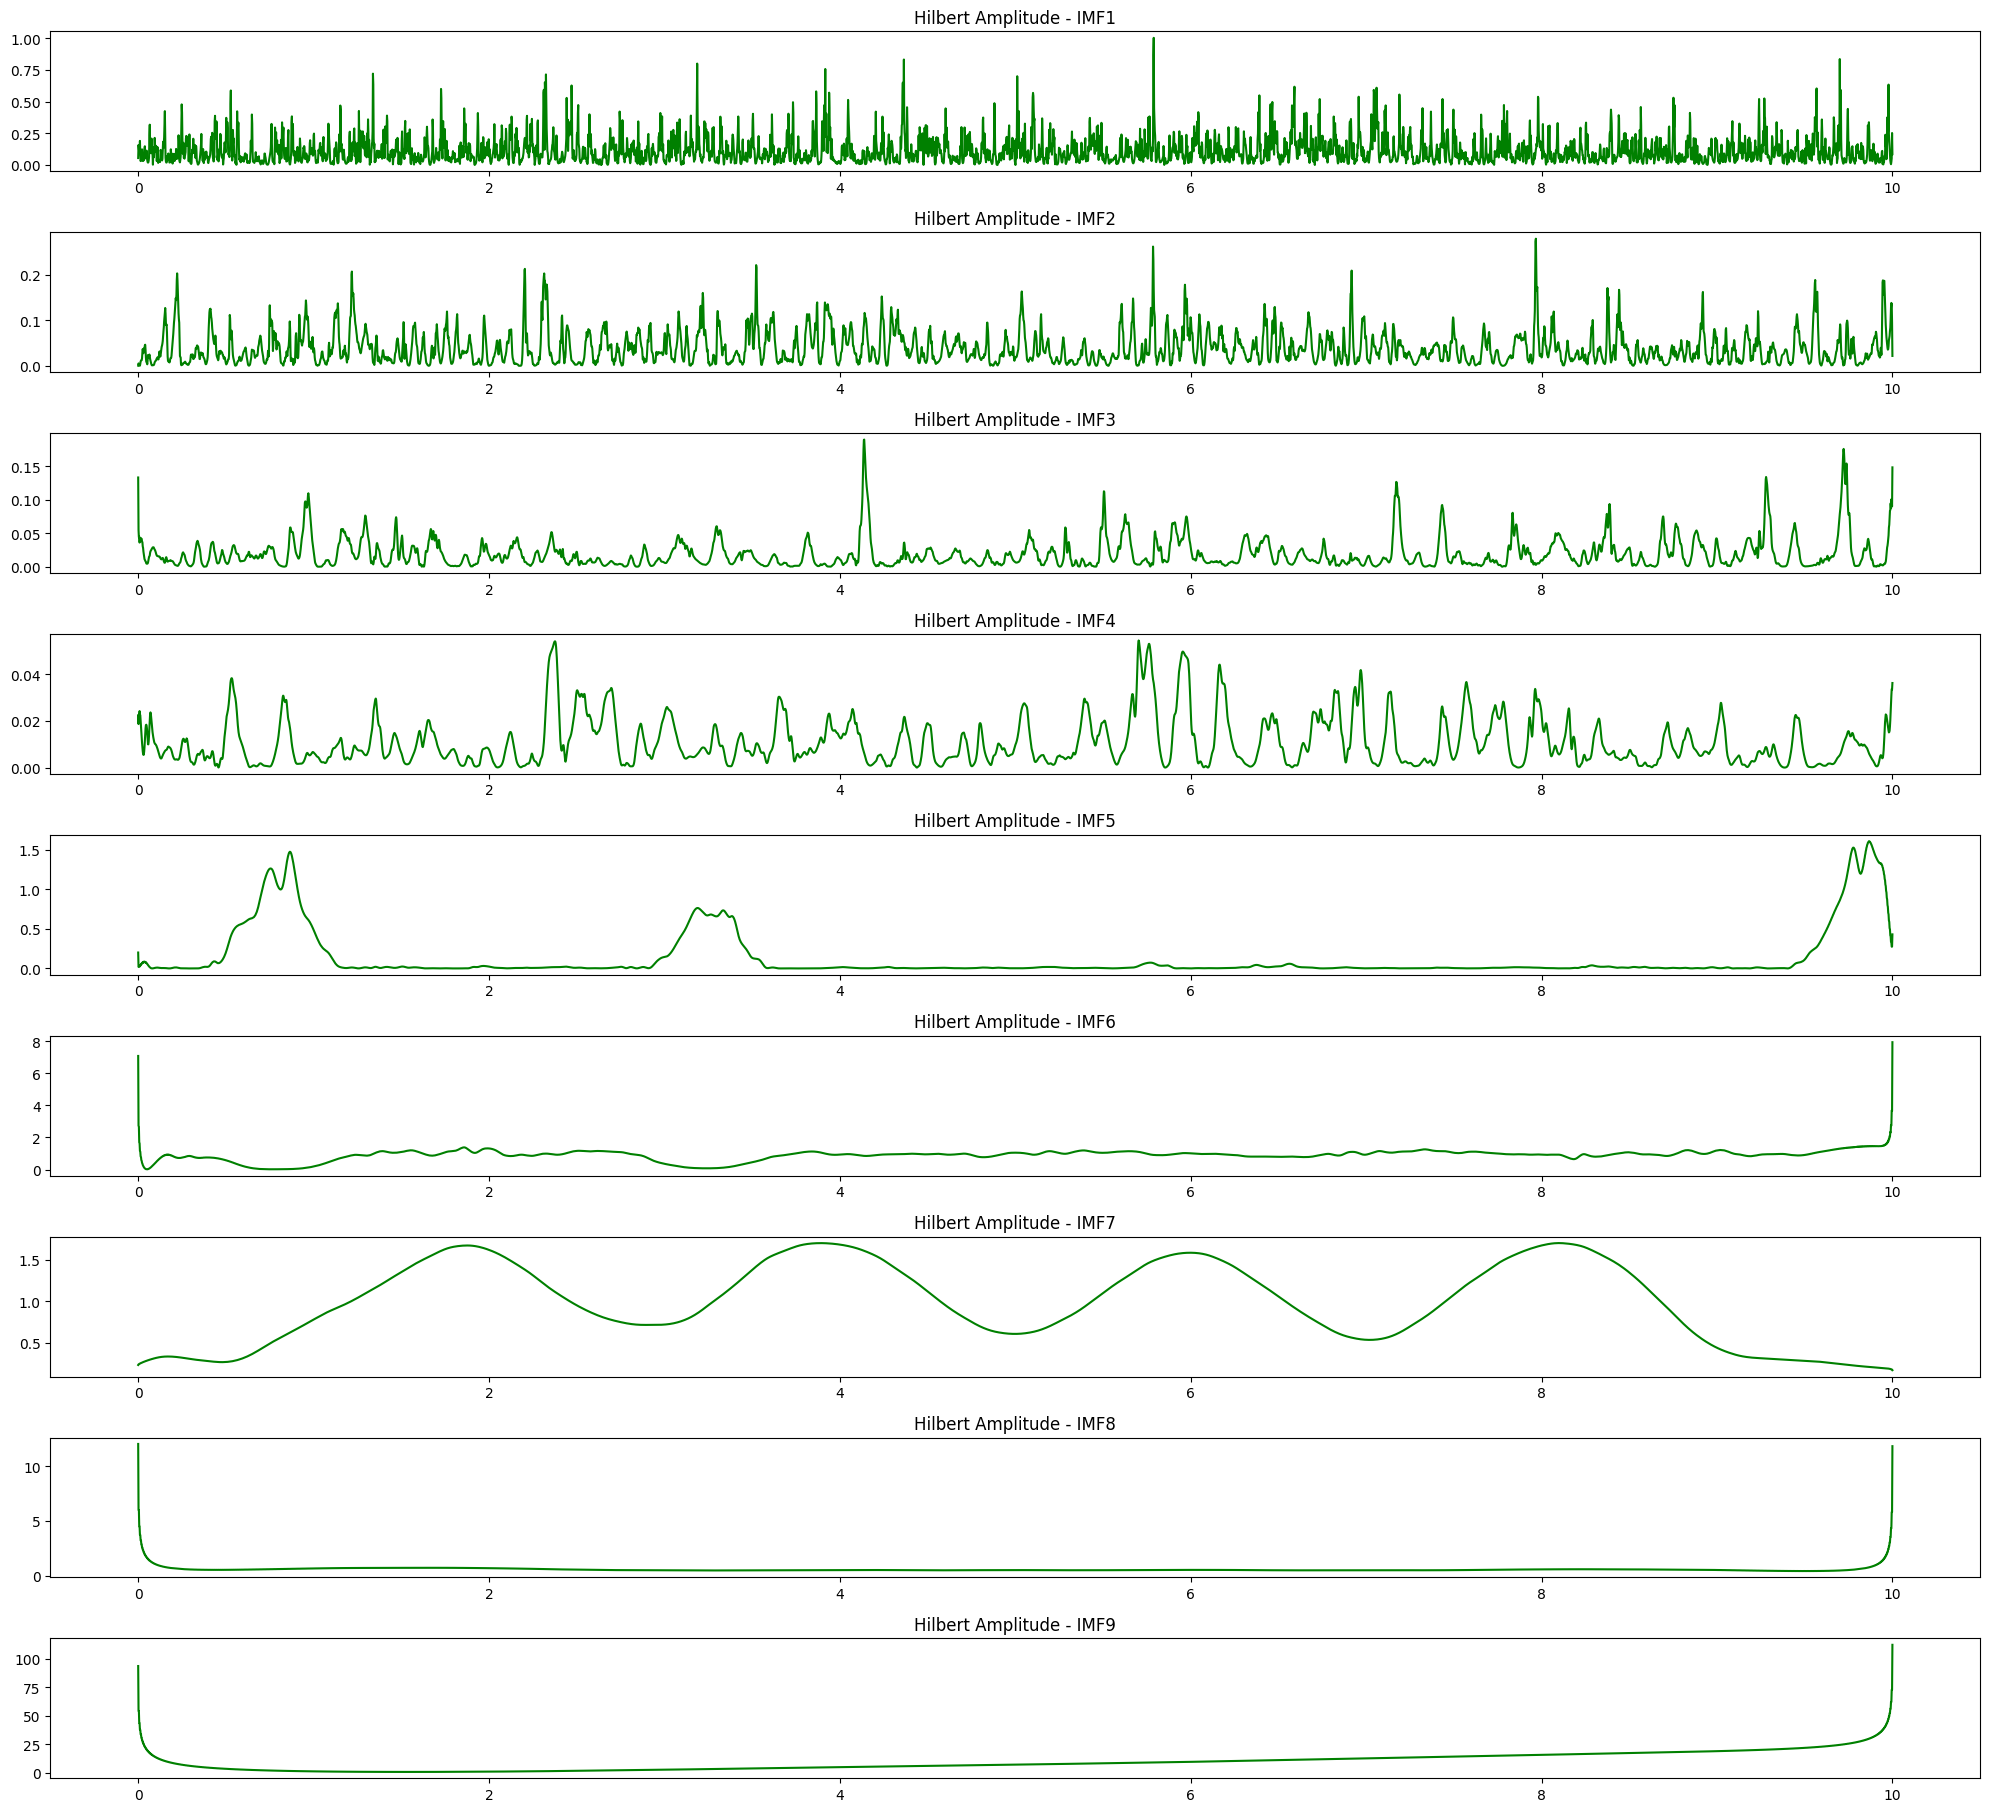

In [4]:
# ======================
# Hilbert Transform Analysis
# ======================
analytic_signal = hilbert(IMFs)
amplitude = np.abs(analytic_signal) ** 2  # Instantaneous energy

plt.figure(figsize=(20, 2 * (len(IMFs) + 1)))
for i, amp in enumerate(amplitude):
    plt.subplot(len(IMFs) + 1, 1, i + 1)
    plt.plot(t, amp, 'g')
    plt.title(f'Hilbert Amplitude - IMF{i+1}')
plt.tight_layout()
plt.show()

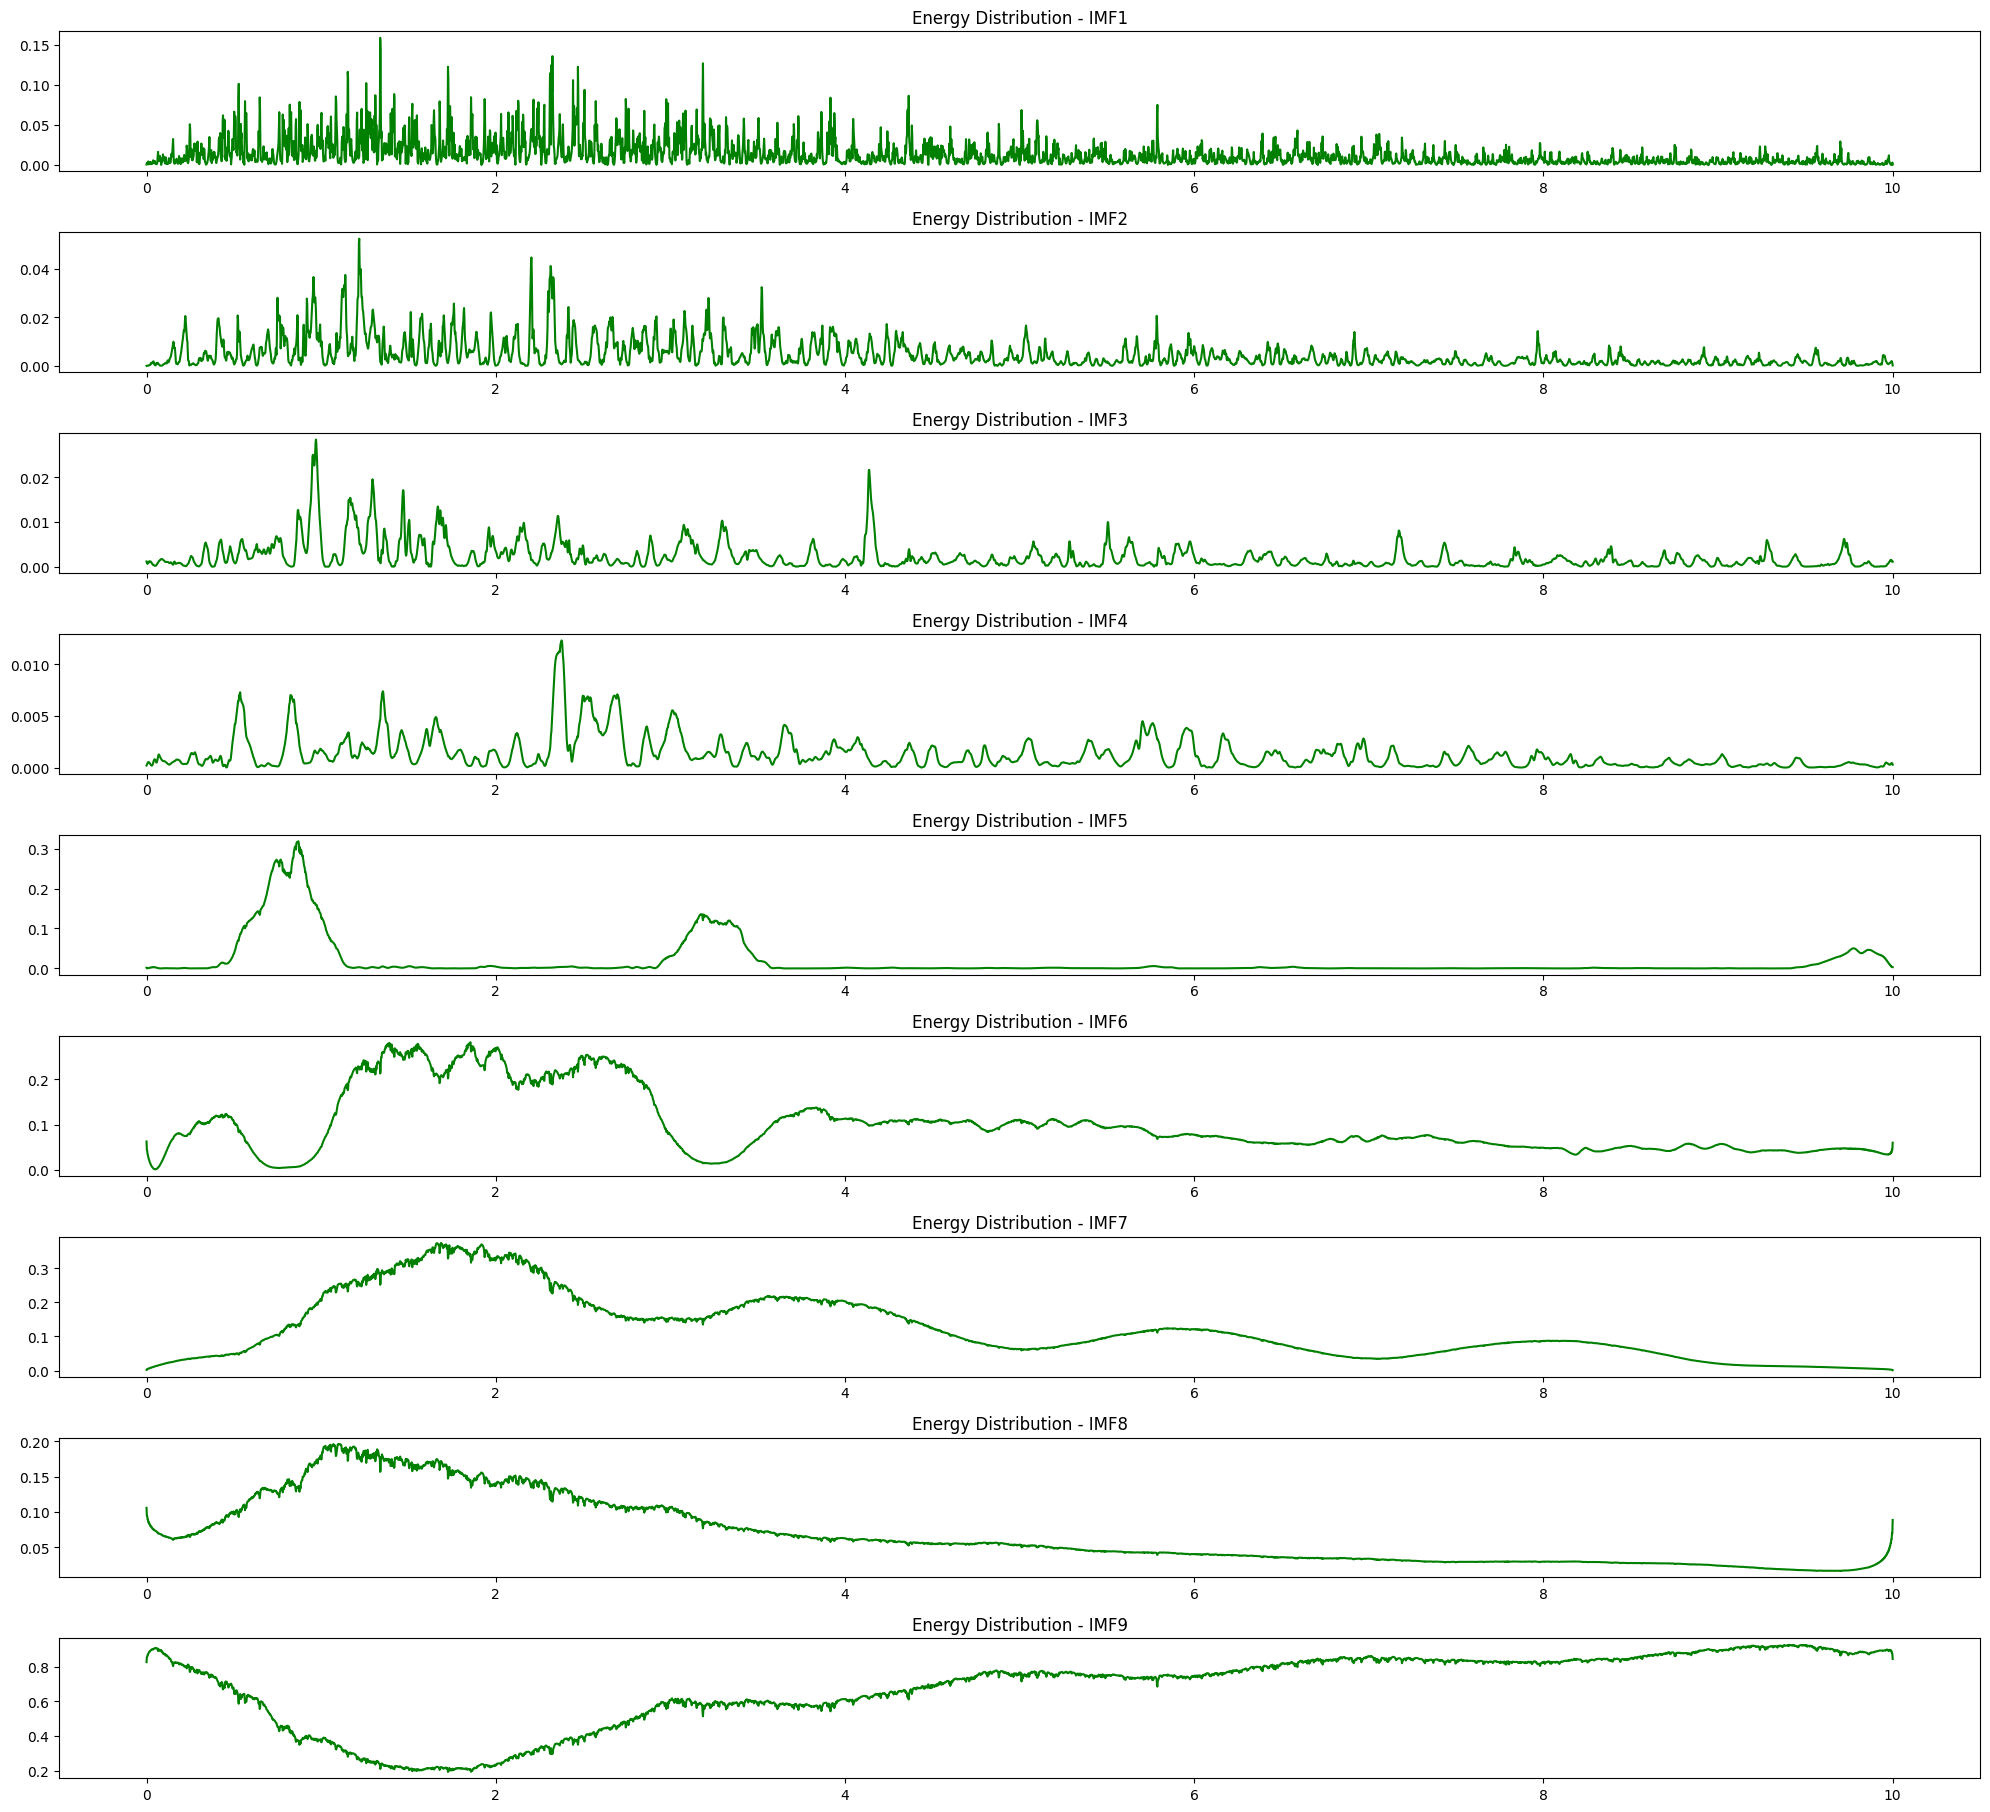

In [5]:
# ======================
# Instantaneous Energy
# ======================
instant_energy = np.sum(amplitude, axis=0)
energy_norm = amplitude / (instant_energy + 1e-10)

plt.figure(figsize=(20, 2 * (len(IMFs) + 1)))
for i, e in enumerate(energy_norm):
    plt.subplot(len(energy_norm) + 1, 1, i + 1)
    plt.plot(t, e, 'g')
    plt.title(f'Energy Distribution - IMF{i+1}')
plt.tight_layout()
plt.show()

[0.01311295 0.00467628 0.002187   0.00126905 0.01754708 0.09724324
 0.12259777 0.06925276 0.67211388]
[0.04356592 0.01586049 0.00804607 0.00431365 0.11289689 0.23173452
 0.30718584 0.16370465 1.08611782]
[-0.01734003 -0.00650792 -0.00367208 -0.00177556 -0.07780274 -0.03724804
 -0.0619903  -0.02519913  0.25810994]
[4 5 6 7 8]


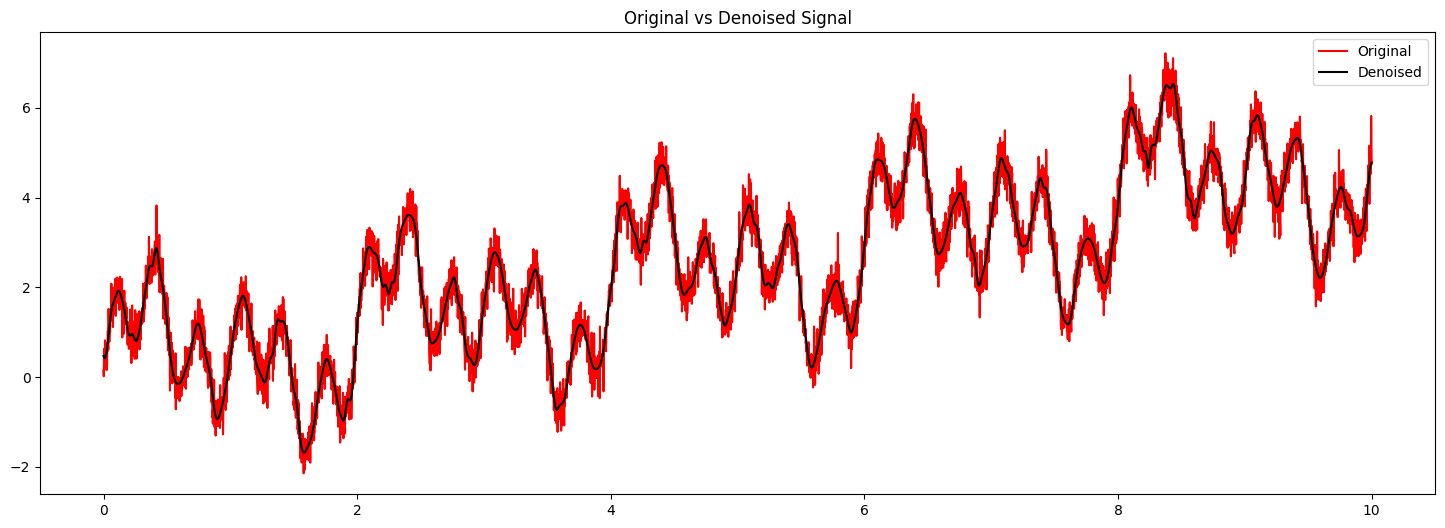

In [6]:
# ======================
# Denoising (Keep IMFs with high mean contribution)
# ======================
means = np.mean(energy_norm, axis=1)
print(means)

variances = np.var(energy_norm, axis=1)
upper_bound = means + 1.96*np.sqrt(variances)
lower_bound = means - 1.96*np.sqrt(variances)

print(upper_bound)
print(lower_bound)

threshold = 0.015
signal_idx = np.where(means > threshold)[0]
print(signal_idx)

denoised_signal = np.sum(IMFs[signal_idx, :], axis=0)

plt.figure(figsize=(18, 6))
plt.plot(t, signal, 'r', label='Original')
plt.plot(t, denoised_signal, 'black', label='Denoised')
plt.title("Original vs Denoised Signal")
plt.legend()
plt.show()

# Comparison

## 1. ML Prediction


Original Prediction
 RMSE: 0.345586
 MAE:  0.276371
 R²:   0.895811

Denoised Prediction
 RMSE: 0.289612
 MAE:  0.230335
 R²:   0.926828


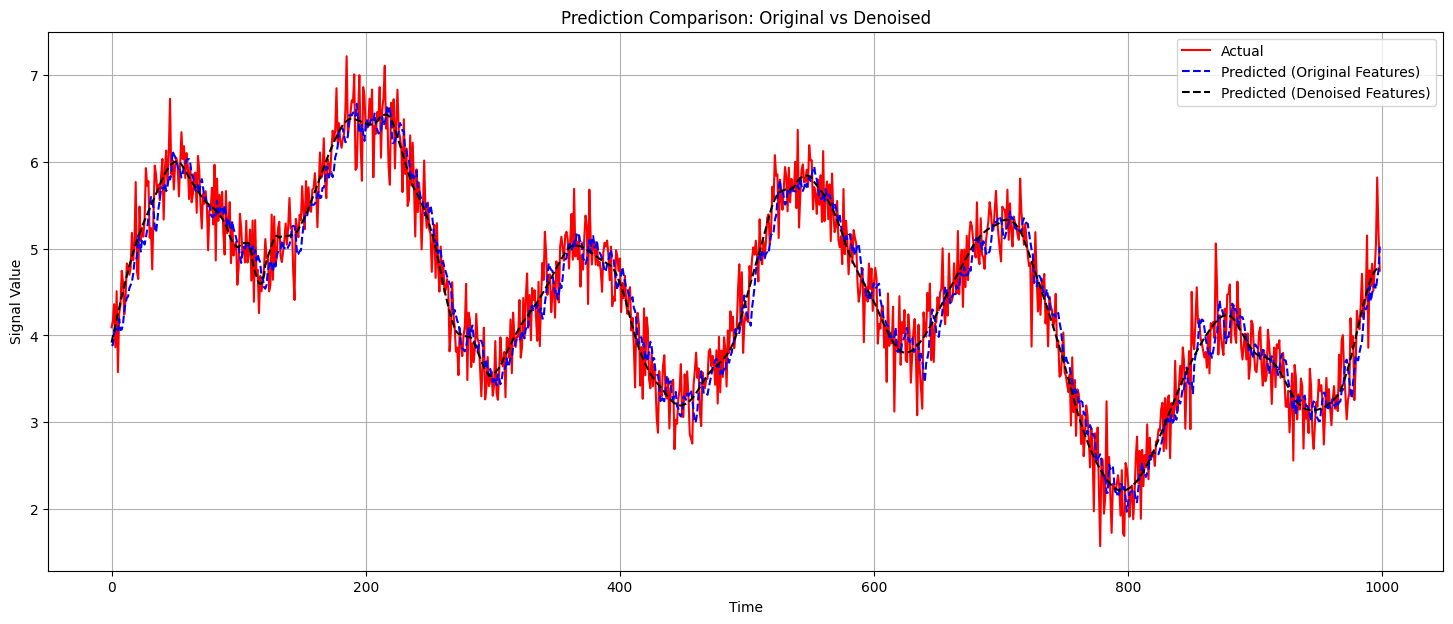

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ===========================
# Feature Engineering Function
# ===========================
def build_features(series, target_series, lags=5):
    df = pd.DataFrame({"feature": series, "target": target_series})

    for i in range(1, lags + 1):
        df[f"lag_{i}"] = df["feature"].shift(i)

    df = df.dropna()
    X = df[[f"lag_{i}" for i in range(1, lags + 1)]].values
    y = df["target"].shift(-1).dropna().values

    X = X[:-1]  # Align lengths with target
    return X, y


def evaluate_model(model_name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name}")
    print(f" RMSE: {rmse:.6f}")
    print(f" MAE:  {mae:.6f}")
    print(f" R²:   {r2:.6f}")

    return rmse, mae, r2


# =========================================
# Feature Sets
# =========================================
lags = 5

# Important: Target is always ORIGINAL signal
X_orig, y_orig = build_features(signal, signal, lags)
X_den, y_den = build_features(denoised_signal, signal, lags)

# Same split size
min_len = min(len(X_orig), len(X_den))
X_orig = X_orig[-min_len:]
y_orig = y_orig[-min_len:]
X_den = X_den[-min_len:]

split = int(len(X_orig) * 0.8)
Xo_train, Xo_test = X_orig[:split], X_orig[split:]
Xd_train, Xd_test = X_den[:split], X_den[split:]
y_train, y_test = y_orig[:split], y_orig[split:]


# =========================================
# Models
# =========================================
model_orig = LinearRegression()
model_orig.fit(Xo_train, y_train)
pred_orig = model_orig.predict(Xo_test)

model_den = LinearRegression()
model_den.fit(Xd_train, y_train)
pred_den = model_den.predict(Xd_test)


# =========================================
# Evaluation
# =========================================
rmse_o, mae_o, r2_o = evaluate_model("Original Prediction", y_test, pred_orig)
rmse_d, mae_d, r2_d = evaluate_model("Denoised Prediction", y_test, pred_den)


# =========================================
# Visualization
# =========================================
plt.figure(figsize=(18, 7))
plt.plot(y_test, label="Actual", color="red")
plt.plot(pred_orig, '--', label="Predicted (Original Features)", color="blue")
plt.plot(pred_den, '--', label="Predicted (Denoised Features)", color="black")
plt.title("Prediction Comparison: Original vs Denoised")
plt.xlabel("Time")
plt.ylabel("Signal Value")
plt.grid(True)
plt.legend()
plt.show()

## 2. MI Score

In [8]:
from sklearn.metrics import mutual_info_score

print('Original Signal:', mutual_info_score(signal[:-1], signal[1:]))
print('Denoised Signal:', mutual_info_score(denoised_signal[:-1], signal[1:]))

Original Signal: 8.51699317141357
Denoised Signal: 8.51699317141357


## 3. Variance

In [9]:
print('Original Signal:', np.var(np.diff(signal)))
print('Denoised Signal:', np.var(np.diff(denoised_signal)))

Original Signal: 0.18184572087319248
Denoised Signal: 0.0008956690608347912


## 4. SNR

In [10]:
def snr(signal, noise):
    return 10 * np.log10(np.sum(signal**2) / np.sum(noise**2))

noise = signal - denoised_signal

print('SNR:', snr(signal, noise))

SNR: 20.439116169744626


## 5. Volatility Reduction

In [11]:
vol_original = np.std(np.diff(signal))
vol_denoised = np.std(np.diff(denoised_signal))

print('Original:', vol_original)
print('Denoised:', vol_denoised)

Original: 0.42643372389293094
Denoised: 0.029927730632889477
